<a href="https://colab.research.google.com/github/AsaCooperStickland/FlatMinimaInterpretability/blob/main/git_rebasin_Asa_MLP_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Replicating the Git Re-Basin experiments by Stanislav Fort, starting from their codebase (MLP on MNIST)
 
I got excited about the Git Re-Basin paper (https://arxiv.org/abs/2209.04836) yesterday (Sep 14 2022) and since the claims seemed pretty strong I decided to replicate the key results. I started from the codebase the authors put on GitHub (https://github.com/samuela/git-re-basin), and took the relevant bits and pieces, put them into a Colab, and write a one-click-runnable replication.

**tldr: I wasn't able to replicate the key observation that the permutation applied to a network moves it to a linearly connected basin of another** 

I added a lot of analysis on top to make sure I knew what was going on. Some things that seem to be true that I wanted to verify: 

1) the permutation procedure preserves the network exactly as it was in terms of its input-ouput behavior, exactly as it should
2) the (network + permutation)'s weight vector gets non-randomly closer to the network towards which the permutation was developed, as it should

However, the key claim that after the permutation is applied the new network is now **within the same convex, linearly connected basin of the other network, I was not able to replicate**. This is unusual since I literally took bits of code from the author's codebase. If you find a problem with my replication, please let me know on Twitter (@stanislavfort) or via email.

Here's the money plot:
Explanation: I have two networks trained from init (model 1 and model 2), and the permutation from the paper applied to model 2 towards model 1. The model 2 + permutation should be in the same linearly connected basin as model 1, which would suggest a nice linear path of low loss between the aqua triangle and the red circle. However, as you can see, there is a bump! The yellow line isn't a nice connected bridge and  on top of that the loss on the weight space cut defined by the model 1, model 2 and model 2 + permutation shows clearly 3 different basins, not 2, as the key claim would suggest.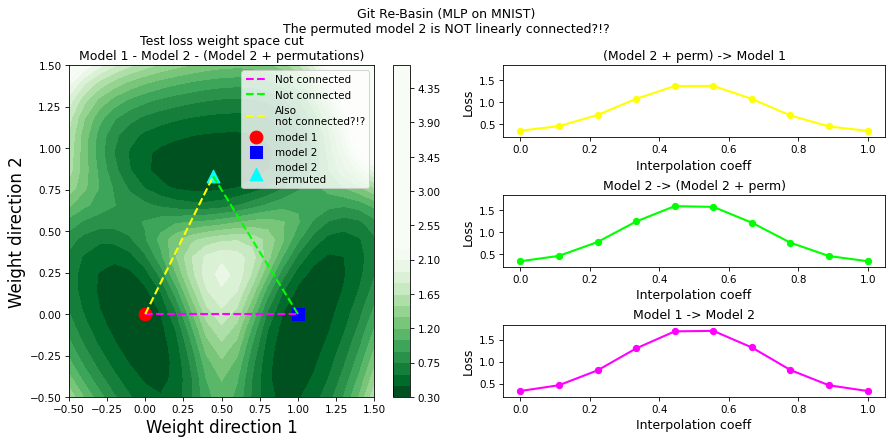

## Library imports

In [ ]:
!pip install augmax
# Install the newest JAXlib version.
!pip install --upgrade -q pip jax jaxlib
# Install Flax at head:
!pip install --upgrade -q git+https://github.com/google/flax.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 15.6 MB/s 
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.1/145.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 11.6 MB/s eta 0:00:00


## Permutation utils

In [ ]:
from collections import defaultdict
from typing import NamedTuple

import jax.numpy as jnp
from jax import random
from scipy.optimize import linear_sum_assignment


class PermutationSpec(NamedTuple):
  perm_to_axes: dict
  axes_to_perm: dict

# def mlp_permutation_spec(num_hidden_layers: int) -> PermutationSpec:
#   """We assume that one permutation cannot appear in two axes of the same weight array."""
#   assert num_hidden_layers >= 1
#   return PermutationSpec(
#       perm_to_axes={
#           f"P_{i}": [(f"Dense_{i}/kernel", 1), (f"Dense_{i}/bias", 0), (f"Dense_{i+1}/kernel", 0)]
#           for i in range(num_hidden_layers)
#       },
#       axes_to_perm={
#           "Dense_0/kernel": (None, "P_0"),
#           **{f"Dense_{i}/kernel": (f"P_{i-1}", f"P_{i}")
#              for i in range(1, num_hidden_layers)},
#           **{f"Dense_{i}/bias": (f"P_{i}", )
#              for i in range(num_hidden_layers)},
#           f"Dense_{num_hidden_layers}/kernel": (f"P_{num_hidden_layers-1}", None),
#           f"Dense_{num_hidden_layers}/bias": (None, ),
#       })

def permutation_spec_from_axes_to_perm(axes_to_perm: dict) -> PermutationSpec:
  perm_to_axes = defaultdict(list)
  for wk, axis_perms in axes_to_perm.items():
    for axis, perm in enumerate(axis_perms):
      if perm is not None:
        perm_to_axes[perm].append((wk, axis))
  return PermutationSpec(perm_to_axes=dict(perm_to_axes), axes_to_perm=axes_to_perm)

def mlp_permutation_spec(num_hidden_layers: int) -> PermutationSpec:
  """We assume that one permutation cannot appear in two axes of the same weight array."""
  assert num_hidden_layers >= 1
  return permutation_spec_from_axes_to_perm({
      "Dense_0/kernel": (None, "P_0"),
      **{f"Dense_{i}/kernel": (f"P_{i-1}", f"P_{i}")
         for i in range(1, num_hidden_layers)},
      **{f"Dense_{i}/bias": (f"P_{i}", )
         for i in range(num_hidden_layers)},
      f"Dense_{num_hidden_layers}/kernel": (f"P_{num_hidden_layers-1}", None),
      f"Dense_{num_hidden_layers}/bias": (None, ),
  })

def vgg16_permutation_spec() -> PermutationSpec:
  return permutation_spec_from_axes_to_perm({
      "Conv_0/kernel": (None, None, None, "P_Conv_0"),
      **{f"Conv_{i}/kernel": (None, None, f"P_Conv_{i-1}", f"P_Conv_{i}")
         for i in range(1, 13)},
      **{f"Conv_{i}/bias": (f"P_Conv_{i}", )
         for i in range(13)},
      **{f"LayerNorm_{i}/scale": (f"P_Conv_{i}", )
         for i in range(13)},
      **{f"LayerNorm_{i}/bias": (f"P_Conv_{i}", )
         for i in range(13)},
      "Dense_0/kernel": ("P_Conv_12", "P_Dense_0"),
      "Dense_0/bias": ("P_Dense_0", ),
      "Dense_1/kernel": ("P_Dense_0", "P_Dense_1"),
      "Dense_1/bias": ("P_Dense_1", ),
      "Dense_2/kernel": ("P_Dense_1", None),
      "Dense_2/bias": (None, ),
  })

def resnet20_permutation_spec() -> PermutationSpec:
  conv = lambda name, p_in, p_out: {f"{name}/kernel": (None, None, p_in, p_out)}
  norm = lambda name, p: {f"{name}/scale": (p, ), f"{name}/bias": (p, )}
  dense = lambda name, p_in, p_out: {f"{name}/kernel": (p_in, p_out), f"{name}/bias": (p_out, )}

  # This is for easy blocks that use a residual connection, without any change in the number of channels.
  easyblock = lambda name, p: {
      **conv(f"{name}/conv1", p, f"P_{name}_inner"),
      **norm(f"{name}/norm1", f"P_{name}_inner"),
      **conv(f"{name}/conv2", f"P_{name}_inner", p),
      **norm(f"{name}/norm2", p)
  }

  # This is for blocks that use a residual connection, but change the number of channels via a Conv.
  shortcutblock = lambda name, p_in, p_out: {
      **conv(f"{name}/conv1", p_in, f"P_{name}_inner"),
      **norm(f"{name}/norm1", f"P_{name}_inner"),
      **conv(f"{name}/conv2", f"P_{name}_inner", p_out),
      **norm(f"{name}/norm2", p_out),
      **conv(f"{name}/shortcut/layers_0", p_in, p_out),
      **norm(f"{name}/shortcut/layers_1", p_out),
  }

  return permutation_spec_from_axes_to_perm({
      **conv("conv1", None, "P_bg0"),
      **norm("norm1", "P_bg0"),
      #
      **easyblock("blockgroups_0/blocks_0", "P_bg0"),
      **easyblock("blockgroups_0/blocks_1", "P_bg0"),
      **easyblock("blockgroups_0/blocks_2", "P_bg0"),
      #
      **shortcutblock("blockgroups_1/blocks_0", "P_bg0", "P_bg1"),
      **easyblock("blockgroups_1/blocks_1", "P_bg1"),
      **easyblock("blockgroups_1/blocks_2", "P_bg1"),
      #
      **shortcutblock("blockgroups_2/blocks_0", "P_bg1", "P_bg2"),
      **easyblock("blockgroups_2/blocks_1", "P_bg2"),
      **easyblock("blockgroups_2/blocks_2", "P_bg2"),
      #
      **dense("dense", "P_bg2", None),
  })

def get_permuted_param(ps: PermutationSpec, perm, k: str, params, except_axis=None):
  """Get parameter `k` from `params`, with the permutations applied."""
  w = params[k]
  for axis, p in enumerate(ps.axes_to_perm[k]):
    # Skip the axis we're trying to permute.
    if axis == except_axis:
      continue

    # None indicates that there is no permutation relevant to that axis.
    if p is not None:
      w = jnp.take(w, perm[p], axis=axis)

  return w

def apply_permutation(ps: PermutationSpec, perm, params):
  """Apply a `perm` to `params`."""
  return {k: get_permuted_param(ps, perm, k, params) for k in params.keys()}

def weight_matching(rng, ps: PermutationSpec, params_a, params_b, max_iter=100, init_perm=None):
  """Find a permutation of `params_b` to make them match `params_a`."""
  perm_sizes = {p: params_a[axes[0][0]].shape[axes[0][1]] for p, axes in ps.perm_to_axes.items()}

  perm = {p: jnp.arange(n) for p, n in perm_sizes.items()} if init_perm is None else init_perm
  perm_names = list(perm.keys())

  for iteration in range(max_iter):
    progress = False
    for p_ix in random.permutation(rngmix(rng, iteration), len(perm_names)):
      p = perm_names[p_ix]
      n = perm_sizes[p]
      A = jnp.zeros((n, n))
      for wk, axis in ps.perm_to_axes[p]:
        w_a = params_a[wk]
        w_b = get_permuted_param(ps, perm, wk, params_b, except_axis=axis)
        w_a = jnp.moveaxis(w_a, axis, 0).reshape((n, -1))
        w_b = jnp.moveaxis(w_b, axis, 0).reshape((n, -1))
        A += w_a @ w_b.T

      ri, ci = linear_sum_assignment(A, maximize=True)
      assert (ri == jnp.arange(len(ri))).all()

      oldL = jnp.vdot(A, jnp.eye(n)[perm[p]])
      newL = jnp.vdot(A, jnp.eye(n)[ci, :])
      print(f"{iteration}/{p}: {newL - oldL}")
      progress = progress or newL > oldL + 1e-12

      perm[p] = jnp.array(ci)

    if not progress:
      break

  return perm

def test_weight_matching():
  """If we just have a single hidden layer then it should converge after just one step."""
  ps = mlp_permutation_spec(num_hidden_layers=1)
  rng = random.PRNGKey(123)
  num_hidden = 10
  shapes = {
      "Dense_0/kernel": (2, num_hidden),
      "Dense_0/bias": (num_hidden, ),
      "Dense_1/kernel": (num_hidden, 3),
      "Dense_1/bias": (3, )
  }
  params_a = {k: random.normal(rngmix(rng, f"a-{k}"), shape) for k, shape in shapes.items()}
  params_b = {k: random.normal(rngmix(rng, f"b-{k}"), shape) for k, shape in shapes.items()}
  perm = weight_matching(rng, ps, params_a, params_b)
  print(perm)



## Utils

In [ ]:
import operator
import re
import time

import jax.numpy as jnp
from flax import traverse_util
from flax.core import freeze, unfreeze
from jax import random, tree_map
from jax.tree_util import tree_reduce

rngmix = lambda rng, x: random.fold_in(rng, hash(x))

class RngPooper:
  """A stateful wrapper around stateless random.PRNGKey's."""

  def __init__(self, init_rng):
    self.rng = init_rng

  def poop(self):
    self.rng, rng_key = random.split(self.rng)
    return rng_key

def l1prox(x, alpha):
  return jnp.sign(x) * jnp.maximum(0, jnp.abs(x) - alpha)

def flatten_params(params):
  return {"/".join(k): v for k, v in traverse_util.flatten_dict(unfreeze(params)).items()}

def unflatten_params(flat_params):
  return freeze(
      traverse_util.unflatten_dict({tuple(k.split("/")): v
                                    for k, v in flat_params.items()}))

def merge_params(a, b):
  return unflatten_params({**a, **b})

def kmatch(pattern, key):
  regex = "^"
  i = 0
  while i < len(pattern):
    if pattern[i] == "*":
      if i + 1 < len(pattern) and pattern[i + 1] == "*":
        regex += "(.*)"
        i += 2
      else:
        regex += "([^\/]*)"
        i += 1
    else:
      regex += pattern[i]
      i += 1
  regex += "$"
  return re.fullmatch(regex, key)

assert kmatch("*", "a") is not None
assert kmatch("*", "a").group(0) == "a"
assert kmatch("*", "a").group(1) == "a"
assert kmatch("abc", "def") is None
assert kmatch("abc/*/ghi", "abc/def/ghi").group(1) == "def"
assert kmatch("abc/**/jkl", "abc/def/ghi/jkl").group(1) == "def/ghi"
assert kmatch("abc/*/jkl", "abc/def/ghi/jkl") is None
assert kmatch("**/*", "abc/def/ghi/jkl").group(1) == "abc/def/ghi"
assert kmatch("**/*", "abc/def/ghi/jkl").group(2) == "jkl"


## Define model

In [ ]:

"""Train an MLP on MNIST on one random seed. Serialize the model for
interpolation downstream."""
import argparse

import augmax
import flax
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow as tf
import tensorflow_datasets as tfds

from flax import linen as nn
from flax.training.train_state import TrainState
from jax import jit, random, tree_map, value_and_grad, vmap, grad, jacfwd, jacrev
from tqdm import tqdm

# See https://github.com/tensorflow/tensorflow/issues/53831.

# See https://github.com/google/jax/issues/9454.
tf.config.set_visible_devices([], "GPU")

activation = nn.relu

class MLPModel(nn.Module):

  @nn.compact
  def __call__(self, x):
    x = jnp.reshape(x, (-1, 28 * 28))
    x = nn.Dense(512)(x)
    a1 = activation(x)
    x = nn.Dense(512)(a1)
    a2 = activation(x)
    x = nn.Dense(512)(a2)
    a3 = activation(x)
    x = nn.Dense(10)(a3)
    x = nn.log_softmax(x)
    return x

def make_stuff(model):
  normalize_transform = augmax.ByteToFloat()
 
  # @jit
  # def hutchinson_trace_autodiff(model, loss, V):
  #   """Hessian trace estimate using autodiff HVPs."""
  #   trace = 0

 #    for _ in range(V):
  #       vec = [rademacher(p.shape) for p in model.parameters()]
  #       Hvec = hvp(loss, list(model.parameters()), vec)

 #        for v, Hv in zip(vec, Hvec):
  #           vHv = torch.einsum("i,i->", v.flatten(), Hv.flatten())
  #           trace += vHv / V

 #    return trace

  # @jit
  # def hvp(f, x, v):
  #   return grad(lambda x: jnp.vdot(grad(f)(x), v))(x)
  @jit
  def hessian(f):
    return jacfwd(jacrev(f))
  
  @jit
  def batch_loss(params, images_u8, labels):
    images_f32 = vmap(normalize_transform)(None, images_u8)
    logits = model.apply({"params": params}, images_f32)
    y_onehot = jax.nn.one_hot(labels, 10)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=y_onehot))
    return loss

  @jit
  def batch_eval(params, images_u8, labels):
    images_f32 = vmap(normalize_transform)(None, images_u8)
    logits = model.apply({"params": params}, images_f32)
    y_onehot = jax.nn.one_hot(labels, 10)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=y_onehot))
    num_correct = jnp.sum(jnp.argmax(logits, axis=-1) == jnp.argmax(y_onehot, axis=-1))
    return loss, {"num_correct": num_correct}

  @jit
  def batch_eval_hessian(params, images_u8, labels, fisher_weight):
    images_f32 = vmap(normalize_transform)(None, images_u8)
    logits = model.apply({"params": params}, images_f32)
    y_onehot = jax.nn.one_hot(labels, 10)
    # (l, info), g = value_and_grad(batch_eval, has_aux=True)(train_state.params, images_f32, labels)
    grad = jax.grad(batch_loss)(params, images_u8, labels)
    trace = jnp.sum(jnp.square(jax.flatten_util.ravel_pytree(grad)[0]))
    # trace = sum(jnp.sum(jnp.square(x)) for x in jax.tree_util.tree_leaves(g))
    # jax.debug.print('tr ', trace)
    # grads_flat, grads_tree_def = jax.tree_util.tree_flatten(g)
    # grad_norms = vmap(optax.linear_algebra.global_norm)(grads_flat)
    # trace = jnp.sum(grad_norms)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=y_onehot))
    # jax.debug.print('before', loss)
    loss_trace = loss + fisher_weight * trace
    # jax.debug.print('after', loss)
    num_correct = jnp.sum(jnp.argmax(logits, axis=-1) == jnp.argmax(y_onehot, axis=-1))
    return loss_trace, {"num_correct": num_correct, "loss_before": loss}

  # Stan's addition for saving predictions of the model to see how they differ
  @jit
  def batch_predictions(params, images_u8, labels):
    images_f32 = vmap(normalize_transform)(None, images_u8)
    logits = model.apply({"params": params}, images_f32)
    y_onehot = jax.nn.one_hot(labels, 10)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=y_onehot))
    num_correct = jnp.sum(jnp.argmax(logits, axis=-1) == jnp.argmax(y_onehot, axis=-1))
    return loss, logits, y_onehot, {"num_correct": num_correct}

  @jit
  def step(train_state, images_f32, labels):
    (l, info), g = value_and_grad(batch_eval, has_aux=True)(train_state.params, images_f32, labels)
    return train_state.apply_gradients(grads=g), {"batch_loss": l, **info}
    
  @jit
  def step_hessian(train_state, images_f32, labels, fisher_weight):
    (l, info), g = value_and_grad(batch_eval_hessian, has_aux=True)(train_state.params, images_f32, labels, fisher_weight)
    return train_state.apply_gradients(grads=g), {"batch_loss": l, **info}

  def dataset_loss_and_accuracy(params, dataset, batch_size: int):
    num_examples = dataset["images_u8"].shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size
    batch_ix = jnp.arange(num_examples).reshape((num_batches, batch_size))
    # Can't use vmap or run in a single batch since that overloads GPU memory.
    losses, infos = zip(*[
        batch_eval(
            params,
            dataset["images_u8"][batch_ix[i, :], :, :, :],
            dataset["labels"][batch_ix[i, :]],
        ) for i in range(num_batches)
    ])
    return (
        jnp.sum(batch_size * jnp.array(losses)) / num_examples,
        sum(x["num_correct"] for x in infos) / num_examples,
    )

  # Stan's addition for saving predictions of the model to see how they differ
  def dataset_predictions(params, dataset, batch_size: int):
    num_examples = dataset["images_u8"].shape[0]
    assert num_examples % batch_size == 0
    num_batches = num_examples // batch_size
    batch_ix = jnp.arange(num_examples).reshape((num_batches, batch_size))
    # Can't use vmap or run in a single batch since that overloads GPU memory.
    losses, logits, y_onehots, infos = zip(*[
        batch_predictions(
            params,
            dataset["images_u8"][batch_ix[i, :], :, :, :],
            dataset["labels"][batch_ix[i, :]],
        ) for i in range(num_batches)
    ])
    return (
        jnp.sum(batch_size * jnp.array(losses)) / num_examples,
        sum(x["num_correct"] for x in infos) / num_examples,
        logits,
        y_onehots,
    )

  return {
      "normalize_transform": normalize_transform,
      "batch_eval": batch_eval,
      "step": step,
      "step_hessian": step_hessian,
      "dataset_loss_and_accuracy": dataset_loss_and_accuracy,
      "dataset_predictions": dataset_predictions,
  }


def load_datasets():
  """Return the training and test datasets, unbatched."""
  # See https://www.tensorflow.org/datasets/overview#as_batched_tftensor_batch_size-1.
  train_ds_images_u8, train_ds_labels = tfds.as_numpy(
      tfds.load("mnist", split="train", batch_size=-1, as_supervised=True))
  test_ds_images_u8, test_ds_labels = tfds.as_numpy(
      tfds.load("mnist", split="test", batch_size=-1, as_supervised=True))
  train_ds = {"images_u8": train_ds_images_u8, "labels": train_ds_labels}
  test_ds = {"images_u8": test_ds_images_u8, "labels": test_ds_labels}
  return train_ds, test_ds



## Runs details

In [ ]:
num_epochs = 20
batch_size = 500
seed = 12421
config_optimizer = "sgd" #"adam"
learning_rate = 1e-2
fisher_weight = 0.5

runs_to_collect = 2 #Stan's new stuff
hessian = True

rng = random.PRNGKey(seed)

In [28]:
# storing model params after training
flattened_models_list = []

for run_i in range(runs_to_collect):

  rng = random.PRNGKey(seed+run_i) # chaning the seed each run 
  rngmix = lambda rng, x: random.fold_in(rng, hash(x))

  model = MLPModel()
  stuff = make_stuff(model)

  print("--------------------------")
  print(f"Starting run {run_i}")


  train_ds, test_ds = load_datasets()
  print("train_ds labels hash", hash(np.array(train_ds["labels"]).tobytes()))
  print("test_ds labels hash", hash(np.array(test_ds["labels"]).tobytes()))

  num_train_examples = train_ds["images_u8"].shape[0]
  num_test_examples = test_ds["images_u8"].shape[0]
  assert num_train_examples % batch_size == 0
  print("num_train_examples", num_train_examples)
  print("num_test_examples", num_test_examples)

  if config_optimizer == "sgd":
    # See runs:
    # * https://wandb.ai/skainswo/playing-the-lottery/runs/3blb4uhm
    # * https://wandb.ai/skainswo/playing-the-lottery/runs/174j7umt
    # * https://wandb.ai/skainswo/playing-the-lottery/runs/td02y8gg
    lr_schedule = optax.warmup_cosine_decay_schedule(
        init_value=1e-6,
        peak_value=learning_rate,
        warmup_steps=10,
        # Confusingly, `decay_steps` is actually the total number of steps,
        # including the warmup.
        decay_steps=num_epochs * (num_train_examples // batch_size),
    )
    tx = optax.sgd(lr_schedule, momentum=0.9)
  elif config_optimizer == "adam":
    # See runs:
    # - https://wandb.ai/skainswo/playing-the-lottery/runs/1b1gztfx (trim-fire-575)
    # - https://wandb.ai/skainswo/playing-the-lottery/runs/1hrmw7wr (wild-dream-576)
    tx = optax.adam(learning_rate)
  else:
    # See runs:
    # - https://wandb.ai/skainswo/playing-the-lottery/runs/k4luj7er (faithful-spaceship-579)
    # - https://wandb.ai/skainswo/playing-the-lottery/runs/3ru7xy8c (sage-forest-580)
    tx = optax.adamw(learning_rate, weight_decay=1e-4)

  train_state = TrainState.create(
      apply_fn=model.apply,
      params=model.init(rngmix(rng, f"init{run_i}"), jnp.zeros((1, 28, 28, 1)))["params"],
      tx=tx,
  )

  for epoch in tqdm(range(num_epochs)):
    infos = []
  
    batch_ix = random.permutation(rngmix(rng, f"epoch-{epoch}"), num_train_examples).reshape(
        (-1, batch_size))
    for i in range(batch_ix.shape[0]):
      p = batch_ix[i, :]
      images_u8 = train_ds["images_u8"][p, :, :, :]
      labels = train_ds["labels"][p]
      if hessian:
        train_state, info = stuff["step_hessian"](train_state, images_u8, labels, fisher_weight)
      else:
        train_state, info = stuff["step"](train_state, images_u8, labels)
      infos.append(info)
    

    train_loss = sum(batch_size * x["batch_loss"] for x in infos) / num_train_examples
    train_loss_before = sum(batch_size * x["loss_before"] for x in infos) / num_train_examples
    print(train_loss_before, "loss")
    print(train_loss, "loss after")
    train_accuracy = sum(x["num_correct"] for x in infos) / num_train_examples

    
    actest_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, test_ds,
                                                                    10_000)

    params_l2 = tree_map(lambda x: jnp.sqrt(jnp.sum(x**2)),
                          flatten_params({"params_l2": train_state.params}))
    
    
  # summary
  print("-----------------")
  print(f"Run {run_i} DONE!")
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, test_ds,
                                                                10_000)
  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, train_ds,
                                                                60_000)
  print(f"Run={run_i} test loss={test_loss} test accuracy={test_accuracy} train loss={train_loss} train accuracy={train_accuracy}")

  flattened_models_list.append(flatten_params(train_state.params))


--------------------------
Starting run 0
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


  0%|          | 0/20 [00:00<?, ?it/s]

1.535606 loss
1.7649207 loss after


 10%|█         | 2/20 [00:03<00:26,  1.49s/it]

0.40783963 loss
0.5871749 loss after


 15%|█▌        | 3/20 [00:03<00:17,  1.02s/it]

0.28633267 loss
0.3835945 loss after


 20%|██        | 4/20 [00:04<00:12,  1.25it/s]

0.23460951 loss
0.31280228 loss after


 25%|██▌       | 5/20 [00:04<00:10,  1.47it/s]

0.20333032 loss
0.28054178 loss after


 30%|███       | 6/20 [00:05<00:08,  1.65it/s]

0.17630023 loss
0.23901962 loss after


 35%|███▌      | 7/20 [00:05<00:07,  1.79it/s]

0.15944426 loss
0.21815923 loss after


 40%|████      | 8/20 [00:06<00:06,  1.89it/s]

0.14595713 loss
0.19929388 loss after


 45%|████▌     | 9/20 [00:06<00:05,  1.96it/s]

0.13630259 loss
0.18920487 loss after


 50%|█████     | 10/20 [00:07<00:04,  2.02it/s]

0.12699538 loss
0.17433955 loss after


 55%|█████▌    | 11/20 [00:07<00:04,  2.05it/s]

0.1206991 loss
0.16793963 loss after


 60%|██████    | 12/20 [00:08<00:03,  2.08it/s]

0.11556001 loss
0.16069949 loss after


 65%|██████▌   | 13/20 [00:08<00:03,  2.09it/s]

0.111142024 loss
0.15306889 loss after


 70%|███████   | 14/20 [00:09<00:02,  2.11it/s]

0.10778702 loss
0.14911146 loss after


 75%|███████▌  | 15/20 [00:09<00:02,  2.12it/s]

0.105797134 loss
0.14717558 loss after


 80%|████████  | 16/20 [00:09<00:01,  2.13it/s]

0.1040612 loss
0.14333501 loss after


 85%|████████▌ | 17/20 [00:10<00:01,  2.13it/s]

0.10295572 loss
0.14315046 loss after


 90%|█████████ | 18/20 [00:10<00:00,  2.14it/s]

0.10202187 loss
0.13900168 loss after


 95%|█████████▌| 19/20 [00:11<00:00,  2.14it/s]

0.10159866 loss
0.13969766 loss after


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]

0.101438284 loss
0.13869812 loss after
-----------------
Run 0 DONE!


Run=0 test loss=0.10840705782175064 test accuracy=0.9683000445365906 train loss=0.10141175240278244 train accuracy=0.9727666974067688
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


  0%|          | 0/20 [00:00<?, ?it/s]

1.4925756 loss
1.7703469 loss after


 10%|█         | 2/20 [00:02<00:23,  1.32s/it]

0.41803423 loss
0.5734707 loss after


 15%|█▌        | 3/20 [00:03<00:15,  1.07it/s]

0.29023162 loss
0.3836704 loss after


 20%|██        | 4/20 [00:03<00:11,  1.34it/s]

0.24148887 loss
0.33541578 loss after


 25%|██▌       | 5/20 [00:04<00:09,  1.55it/s]

0.20404169 loss
0.27134728 loss after


 30%|███       | 6/20 [00:04<00:08,  1.70it/s]

0.1779312 loss
0.23643571 loss after


 35%|███▌      | 7/20 [00:05<00:07,  1.82it/s]

0.1618572 loss
0.22207929 loss after


 40%|████      | 8/20 [00:05<00:06,  1.90it/s]

0.14818627 loss
0.20478673 loss after


 45%|████▌     | 9/20 [00:06<00:05,  1.96it/s]

0.13707656 loss
0.18619664 loss after


 50%|█████     | 10/20 [00:06<00:04,  2.00it/s]

0.12949054 loss
0.18074843 loss after


 55%|█████▌    | 11/20 [00:07<00:04,  2.01it/s]

0.1221825 loss
0.16640037 loss after


 60%|██████    | 12/20 [00:07<00:03,  2.03it/s]

0.11726159 loss
0.16476151 loss after


 65%|██████▌   | 13/20 [00:08<00:03,  2.05it/s]

0.11303674 loss
0.15617394 loss after


 70%|███████   | 14/20 [00:08<00:02,  2.07it/s]

0.109378025 loss
0.15165466 loss after


 75%|███████▌  | 15/20 [00:09<00:02,  2.08it/s]

0.107158445 loss
0.14827259 loss after


 80%|████████  | 16/20 [00:09<00:01,  2.09it/s]

0.105328955 loss
0.14405961 loss after


 85%|████████▌ | 17/20 [00:10<00:01,  2.09it/s]

0.10410883 loss
0.14221859 loss after


 90%|█████████ | 18/20 [00:10<00:00,  2.09it/s]

0.103299595 loss
0.14229977 loss after


 95%|█████████▌| 19/20 [00:11<00:00,  2.08it/s]

0.102927804 loss
0.1403967 loss after


100%|██████████| 20/20 [00:11<00:00,  1.73it/s]

0.10274561 loss
0.14003661 loss after
-----------------
Run 1 DONE!


Run=1 test loss=0.1100718080997467 test accuracy=0.968500018119812 train loss=0.10271961241960526 train accuracy=0.9725666642189026


In [ ]:
# flattening params
assert len(flattened_models_list) >= 2
flattened_model1 = flattened_models_list[0]
flattened_model2 = flattened_models_list[1]

## Permuting the model

In [30]:
permutation_spec = mlp_permutation_spec(3)
final_permutation = weight_matching(random.PRNGKey(seed), permutation_spec,
                                    flattened_model1, flattened_model2)

SyntaxError: ignored

In [ ]:
# applying the permutation to the second model
flattened_model1_permuted = unflatten_params(
        apply_permutation(permutation_spec, final_permutation, flattened_model1)
        )
flattened_model2_permuted = unflatten_params(
        apply_permutation(permutation_spec, final_permutation, flattened_model2)
        )

## Performance verification

### Model 1

In [ ]:
test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1), test_ds,
                                                                  10_000)
train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1), train_ds,
                                                                  60_000)
print("Model 1")
print(f"train_loss={train_loss} train_accuracy={train_accuracy}")
print(f"test_loss={test_loss} test_accuracy={test_accuracy}")

Model 1
train_loss=0.10964657366275787 train_accuracy=0.9706000089645386
test_loss=0.11621668189764023 test_accuracy=0.9670000672340393


### Model 2

In [ ]:
test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2), test_ds,
                                                                  10_000)
train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2), train_ds,
                                                                  60_000)
print("Model 2")
print(f"train_loss={train_loss} train_accuracy={train_accuracy}")
print(f"test_loss={test_loss} test_accuracy={test_accuracy}")

Model 2
train_loss=0.11283382028341293 train_accuracy=0.9700666666030884
test_loss=0.1190938651561737 test_accuracy=0.966200053691864


### Model 1 with permutation

In [ ]:
test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1_permuted), test_ds,
                                                                  10_000)
train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1_permuted), train_ds,
                                                                  60_000)
print("Model 1 with permutation")
print(f"train_loss={train_loss} train_accuracy={train_accuracy}")
print(f"test_loss={test_loss} test_accuracy={test_accuracy}")

Model 1 with permutation
train_loss=0.10964657366275787 train_accuracy=0.9706000089645386
test_loss=0.11621668189764023 test_accuracy=0.9670000672340393


### Model 2 with permutation

In [ ]:
test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2_permuted), test_ds,
                                                                  10_000)
train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2_permuted), train_ds,
                                                                  60_000)
print("Model 2 with permutation")
print(f"train_loss={train_loss} train_accuracy={train_accuracy}")
print(f"test_loss={test_loss} test_accuracy={test_accuracy}")

Model 2 with permutation
train_loss=0.11283382028341293 train_accuracy=0.9700666666030884
test_loss=0.1190938651561737 test_accuracy=0.966200053691864


## Weight vector analysis

In [ ]:
flattened_model1_permuted_flat = flatten_params(flattened_model1_permuted)
flattened_model2_permuted_flat = flatten_params(flattened_model2_permuted)

In [ ]:
# all in long vectors
keys = flattened_model1.keys()

v1 = jnp.concatenate([flattened_model1[key].reshape([-1]) for key in keys],axis=0)
v2 = jnp.concatenate([flattened_model2[key].reshape([-1]) for key in keys],axis=0)
v1_perm = jnp.concatenate([flattened_model1_permuted_flat[key].reshape([-1]) for key in keys],axis=0)
v2_perm = jnp.concatenate([flattened_model2_permuted_flat[key].reshape([-1]) for key in keys],axis=0)

In [ ]:
vectors_to_show = [
    ("model 1", v1),
    ("model 2", v2),
    ("model 1 + perms", v1_perm),
    ("model 2 + perms", v2_perm), 
]

for vector_str, vector in vectors_to_show:
  print(f"{vector_str} length**2={(jnp.sum(vector**2))}")

# the permutation should preserve the length

model 1 length**2=1612.454345703125
model 2 length**2=1611.523681640625
model 1 + perms length**2=1612.4544677734375
model 2 + perms length**2=1611.523681640625


In [ ]:
coses_grid = np.zeros((len(vectors_to_show),len(vectors_to_show)))
for i,(vector_str1, vector1) in enumerate(vectors_to_show):
  for j,(vector_str2, vector2) in enumerate(vectors_to_show):
    cos_now = jnp.sum(vector1*vector2)/jnp.sqrt(jnp.sum(vector1**2))/jnp.sqrt(jnp.sum(vector2**2))
    print(f"cos({vector_str1},{vector_str2})={cos_now}")
    coses_grid[i,j] = cos_now

cos(model 1,model 1)=1.0000001192092896
cos(model 1,model 2)=0.0034309541806578636
cos(model 1,model 1 + perms)=0.004956461954861879
cos(model 1,model 2 + perms)=0.12146595865488052
cos(model 2,model 1)=0.00343095394782722
cos(model 2,model 2)=1.0
cos(model 2,model 1 + perms)=0.0027334289625287056
cos(model 2,model 2 + perms)=0.005097637418657541
cos(model 1 + perms,model 1)=0.004956461954861879
cos(model 1 + perms,model 2)=0.0027334289625287056
cos(model 1 + perms,model 1 + perms)=1.0
cos(model 1 + perms,model 2 + perms)=0.00343095394782722
cos(model 2 + perms,model 1)=0.12146596610546112
cos(model 2 + perms,model 2)=0.005097637418657541
cos(model 2 + perms,model 1 + perms)=0.0034309537149965763
cos(model 2 + perms,model 2 + perms)=1.0


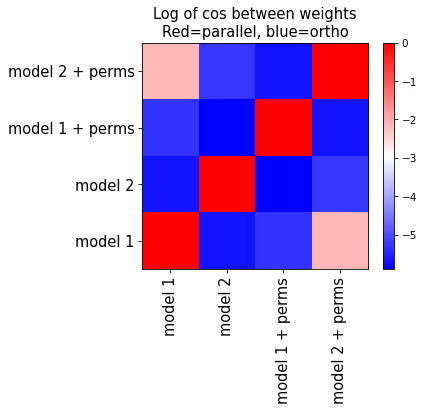

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (5,4),dpi=75)
plt.title("Log of cos between weights\nRed=parallel, blue=ortho",fontsize=14)
fig.patch.set_facecolor('white')
plt.imshow(np.log(np.abs(coses_grid)),cmap=plt.cm.bwr,origin="lower")
plt.xticks(range(len(vectors_to_show)), [x[0] for x in vectors_to_show],rotation = 90,fontsize=14)
plt.yticks(range(len(vectors_to_show)), [x[0] for x in vectors_to_show],fontsize=14)
plt.colorbar()
plt.show()


## Linear interpolations of weights = test for linear mode connectivity

In [31]:
def get_linear_combination(factor1,vector1,factor2,vector2):
  return dict(
      [(key,factor1*vector1[key]+factor2*vector2[key]) for key in vector1.keys()]
  )

### Model 1 -> Model 2

0 0.0 0.11621668
1 0.1111111111111111 0.20105657
2 0.2222222222222222 0.50913835
3 0.3333333333333333 1.0875179
4 0.4444444444444444 1.5609585
5 0.5555555555555556 1.578488
6 0.6666666666666666 1.1245016
7 0.7777777777777777 0.531277
8 0.8888888888888888 0.20696718
9 1.0 0.119093865


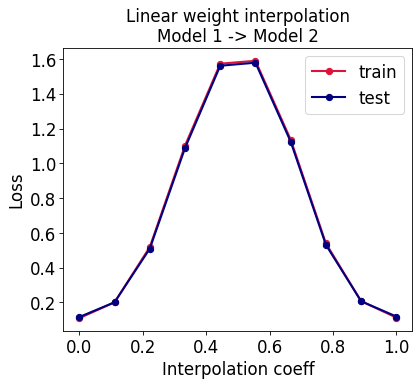

In [ ]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model1
stop_vector = flattened_model2
name = "Model 1 -> Model 2"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  60_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

plt.figure(figsize=(6,5),dpi=75)
plt.gca().patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

### Model 1 -> Model 1 + permutations

0 0.0 0.11621668
1 0.1111111111111111 0.16032222
2 0.2222222222222222 0.27335024
3 0.3333333333333333 0.46193737
4 0.4444444444444444 0.6248136
5 0.5555555555555556 0.6250897
6 0.6666666666666666 0.46219495
7 0.7777777777777777 0.27491942
8 0.8888888888888888 0.1630931
9 1.0 0.119093865


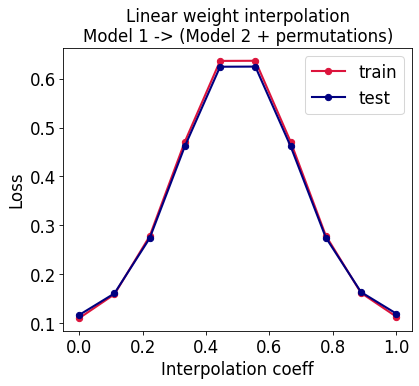

In [ ]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model1
stop_vector = flattened_model2_permuted_flat
name = "Model 1 -> (Model 2 + permutations)"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  60_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

fig = plt.figure(figsize=(6,5),dpi=75)
fig.patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

### Model 2 -> Model 2 + permutations

0 0.0 0.119093865
1 0.1111111111111111 0.20247874
2 0.2222222222222222 0.50188345
3 0.3333333333333333 1.0642691
4 0.4444444444444444 1.5205101
5 0.5555555555555556 1.5268157
6 0.6666666666666666 1.0778216
7 0.7777777777777777 0.5093568
8 0.8888888888888888 0.20382199
9 1.0 0.119093865


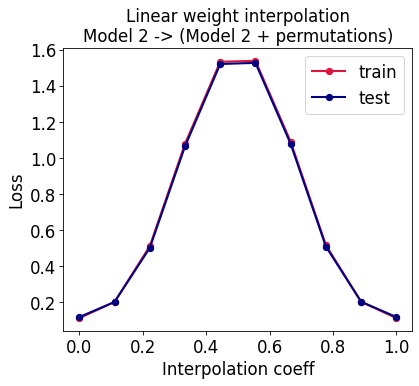

In [ ]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model2
stop_vector = flattened_model2_permuted_flat
name = "Model 2 -> (Model 2 + permutations)"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  60_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

fig = plt.figure(figsize=(6,5),dpi=75)
fig.patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

### Model 2 -> Model 1 + permutations

0 0.0 0.119093865
1 0.1111111111111111 0.20665756
2 0.2222222222222222 0.5315868
3 0.3333333333333333 1.1332749
4 0.4444444444444444 1.5994804
5 0.5555555555555556 1.5851161
6 0.6666666666666666 1.1051615
7 0.7777777777777777 0.5154687
8 0.8888888888888888 0.20222813
9 1.0 0.11621668


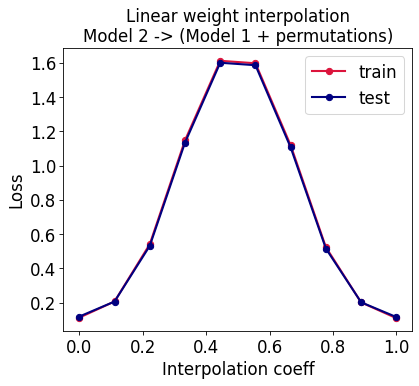

In [ ]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model2
stop_vector = flattened_model1_permuted_flat
name = "Model 2 -> (Model 1 + permutations)"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  60_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

fig = plt.figure(figsize=(6,5),dpi=75)
fig.patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

### Model 1 -> Model 1 + permutations

0 0.0 0.10851285
1 0.1111111111111111 0.18063766
2 0.2222222222222222 0.45246354
3 0.3333333333333333 0.9911569
4 0.4444444444444444 1.4414456
5 0.5555555555555556 1.430885
6 0.6666666666666666 0.97304106
7 0.7777777777777777 0.44453835
8 0.8888888888888888 0.17915209
9 1.0 0.10851285


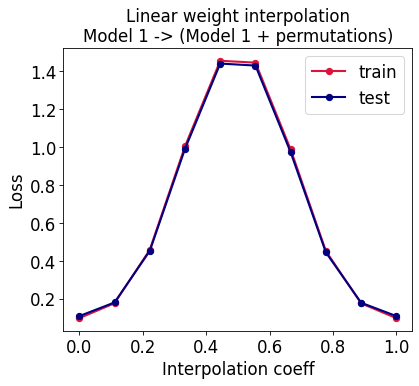

In [ ]:
ts = np.linspace(0.0,1.0,10)

start_vector = flattened_model1
stop_vector = flattened_model1_permuted_flat
name = "Model 1 -> (Model 1 + permutations)"

test_losses_list = []
test_accs_list = []
train_losses_list = []
train_accs_list = []

for i,t in enumerate(ts):
  new_params = get_linear_combination(
      (1.0-t), start_vector, t, stop_vector
  )
  test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                  10_000)
  test_losses_list.append(test_loss)
  test_accs_list.append(test_accuracy)

  train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                  60_000)
  train_losses_list.append(train_loss)
  train_accs_list.append(train_accuracy)

  print(i,t,test_loss)

fig = plt.figure(figsize=(6,5),dpi=75)
fig.patch.set_facecolor('white')
plt.title(f"Linear weight interpolation\n{name}",fontsize=16)
plt.plot(ts,train_losses_list,label="train",marker="o",color="crimson",linewidth=2)
plt.plot(ts,test_losses_list,label="test",marker="o",color="navy",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

## Predictions

In [ ]:
def compare_predictions(
    model1,
    model2,
):

  _, _, logits1, _ = stuff["dataset_predictions"](model1, test_ds,
                                                                    10_000)
  _, _, logits2, _ = stuff["dataset_predictions"](model2, test_ds,
                                                                    10_000)
  
  return jnp.sum(jnp.argmax(logits1[0],axis=-1) != jnp.argmax(logits2[0],axis=-1))
  


In [ ]:
models_to_show = [
    ("model 1", flattened_model1),
    ("model 2", flattened_model2),
    ("model 1 + perms", flattened_model1_permuted_flat),
    ("model 2 + perms", flattened_model2_permuted_flat), 
]

disagreement_grid = np.zeros((len(models_to_show),len(models_to_show)))
for i,(vector_str1, vector1) in enumerate(models_to_show):
  for j,(vector_str2, vector2) in enumerate(models_to_show):
    disagreement_now = compare_predictions(
        unflatten_params(vector1),
        unflatten_params(vector2)
        )
    print(f"Disagreemnt {vector_str1} vs {vector_str2}={disagreement_now}")
    disagreement_grid[i,j] = disagreement_now

Disagreemnt model 1 vs model 1=0
Disagreemnt model 1 vs model 2=1934
Disagreemnt model 1 vs model 1 + perms=1819
Disagreemnt model 1 vs model 2 + perms=1824
Disagreemnt model 2 vs model 1=1934
Disagreemnt model 2 vs model 2=0
Disagreemnt model 2 vs model 1 + perms=1166
Disagreemnt model 2 vs model 2 + perms=1166
Disagreemnt model 1 + perms vs model 1=1819
Disagreemnt model 1 + perms vs model 2=1166
Disagreemnt model 1 + perms vs model 1 + perms=0
Disagreemnt model 1 + perms vs model 2 + perms=105
Disagreemnt model 2 + perms vs model 1=1824
Disagreemnt model 2 + perms vs model 2=1166
Disagreemnt model 2 + perms vs model 1 + perms=105
Disagreemnt model 2 + perms vs model 2 + perms=0


## Loss landscape cuts

In [ ]:
# reconstructing parameter dictionaries from flat vectors
def reconstruct(vector, example_flat_model, keys):
  i = 0
  output = dict()
  for key in keys:
    shape_now = example_flat_model[key].shape
    size_now = np.prod(shape_now)
    data_now = vector[i:i+size_now].reshape(shape_now)
    output[key] = data_now
    i = i + size_now
  return output



In [ ]:
# testing it, should get all 0.0
rec = reconstruct(v1, flattened_model1, flattened_model1.keys())
for key in rec.keys():
  print(jnp.max(jnp.abs(flattened_model1[key] - rec[key])))
  assert jnp.max(jnp.abs(flattened_model1[key] - rec[key])) == 0.0

13.221555


AssertionError: ignored

### Cut model1 - model2 - (model2+perm)

In [ ]:
model1 = flattened_model1
model2 = flattened_model2
model3 = flattened_model2_permuted_flat
cut_str = "Model 1 - Model 2 - (Model 2 + permutations)"

keys = model1.keys()

v1 = jnp.concatenate([model1[key].reshape([-1]) for key in keys],axis=0)
v2 = jnp.concatenate([model2[key].reshape([-1]) for key in keys],axis=0)
v3 = jnp.concatenate([model3[key].reshape([-1]) for key in keys],axis=0)

basis1 = v2-v1
basis1_normed = basis1 / jnp.sqrt(jnp.sum(basis1**2.0))
basis2 = v3 - v1
basis2 = basis2 - jnp.sum(basis2*basis1_normed)*basis1_normed #orthogonalization
basis2_normed = basis2 / jnp.sqrt(jnp.sum(basis2**2.0))

scale = jnp.sqrt(jnp.sum(basis1**2))

t1s = np.linspace(-0.5,1.5,21)
t2s = np.linspace(-0.5,1.5,20)

acc_grid = np.zeros((len(t1s),len(t2s)))
loss_grid = np.zeros((len(t1s),len(t2s)))
logits_grid = np.zeros((len(t1s),len(t2s), 10000, 10))

for i1,t1 in enumerate(t1s):
  print(f"{i1}/{len(t1s)}")
  for i2,t2 in enumerate(t2s):

    new_flat_v = v1 + basis1_normed*t1*scale + basis2_normed*t2*scale
    reconstructed_flat = reconstruct(new_flat_v, model1, keys)
    actest_loss, test_accuracy, logits, onehots = stuff["dataset_predictions"](unflatten_params(reconstructed_flat), test_ds,
                                                                  10_000)
    logits_grid[i1,i2] = np.array(logits[0])
    
    acc_grid[i1,i2] = test_accuracy
    loss_grid[i1,i2] = actest_loss
  
def projection(vector):
  x = jnp.sum((vector - v1)*basis1_normed)/scale
  y = jnp.sum((vector - v1)*basis2_normed)/scale
  return x,y



0/21
1/21
2/21
3/21
4/21
5/21
6/21
7/21
8/21
9/21
10/21
11/21
12/21
13/21
14/21
15/21
16/21
17/21
18/21
19/21
20/21


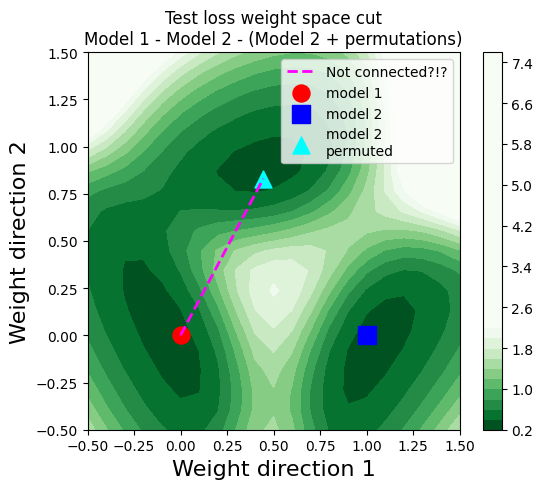

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (6,5),dpi=100)
fig.patch.set_facecolor('white')
plt.title(f"Test loss weight space cut\n{cut_str}")

plt.contourf(t1s,t2s,loss_grid.T,cmap=plt.cm.Greens_r,vmax=2.2,levels=40)
plt.colorbar()

x1,y1 = projection(v1)
plt.scatter([x1],[y1],marker="o",color="red",label="model 1",s=150)

x2,y2 = projection(v2)
plt.scatter([x2],[y2],marker="s",color="blue",label="model 2",s=150)

x2p,y2p = projection(v3)
plt.scatter([x2p],[y2p],marker="^",color="aqua",label="model 2\npermuted",s=150)


plt.plot([x1,x2p],[y1,y2p],linewidth=2,linestyle="--",color="fuchsia",label="Not connected?!?")

plt.xlabel("Weight direction 1",fontsize = 16)
plt.ylabel("Weight direction 2",fontsize = 16)


plt.legend(fontsize=10,ncol=1)

plt.show()

## Combined plot

In [ ]:
def get_linear_cut(start_vector, stop_vector, steps=10):

  ts = np.linspace(0.0,1.0,steps)

  test_losses_list = []
  test_accs_list = []
  train_losses_list = []
  train_accs_list = []

  for i,t in enumerate(ts):
    new_params = get_linear_combination(
        (1.0-t), start_vector, t, stop_vector
    )
    test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), test_ds,
                                                                    10_000)
    test_losses_list.append(test_loss)
    test_accs_list.append(test_accuracy)

    train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(new_params), train_ds,
                                                                    60_000)
    train_losses_list.append(train_loss)
    train_accs_list.append(train_accuracy)

  return ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list


NameError: ignored

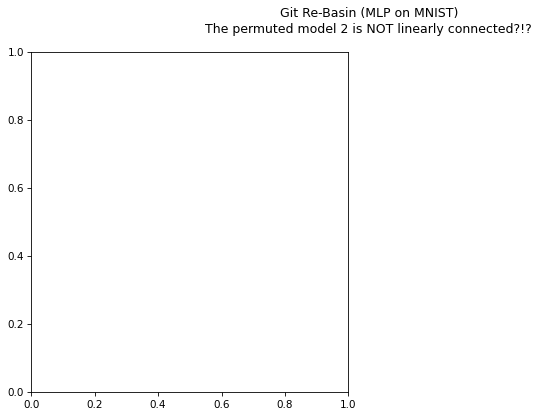

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6), dpi = 75)
fig.patch.set_facecolor('white')

plt.suptitle("Git Re-Basin (MLP on MNIST)\nThe permuted model 2 is NOT linearly connected?!?")

plt.subplot(1,2,1)

plt.title(f"Test loss weight space cut\n{cut_str}")

plt.contourf(t1s,t2s,loss_grid.T,cmap=plt.cm.Greens_r,vmax=2.2,levels=40)
plt.colorbar()

x1,y1 = projection(v1)
plt.scatter([x1],[y1],marker="o",color="red",label="model 1",s=150)

x2,y2 = projection(v2)
plt.scatter([x2],[y2],marker="s",color="blue",label="model 2",s=150)

x2p,y2p = projection(v3)
plt.scatter([x2p],[y2p],marker="^",color="aqua",label="model 2\npermuted",s=150)


plt.plot([x1,x2],[y1,y2],linewidth=2,linestyle="--",color="fuchsia",label="Not connected")
plt.plot([x2,x2p],[y2,y2p],linewidth=2,linestyle="--",color="lime",label="Not connected")
plt.plot([x1,x2p],[y1,y2p],linewidth=2,linestyle="--",color="yellow",label="Also\nnot connected?!?")


plt.xlabel("Weight direction 1",fontsize = 16)
plt.ylabel("Weight direction 2",fontsize = 16)

plt.legend(fontsize=10,ncol=1)

# getting the data
all_test_losses = []
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2_permuted_flat, 10)
all_test_losses += test_losses_list
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model2, flattened_model2_permuted_flat, 10)
all_test_losses += test_losses_list
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2, 10)
all_test_losses += test_losses_list

lower_lim = np.min(test_losses_list)-(np.max(test_losses_list)-np.min(test_losses_list))*0.1
upper_lim = np.max(test_losses_list)+(np.max(test_losses_list)-np.min(test_losses_list))*0.1


plt.subplot(3,2,2)

ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2_permuted_flat, 10)

plt.title(f"(Model 2 + perm) -> Model 1",fontsize=12)
plt.plot(ts,train_losses_list,label="train",marker="o",color="yellow",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=12)
plt.ylabel("Loss",fontsize=12)
plt.ylim([lower_lim, upper_lim])


plt.subplot(3,2,4)
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model2, flattened_model2_permuted_flat, 10)
plt.title(f"Model 2 -> (Model 2 + perm)",fontsize=12)
plt.plot(ts,test_losses_list,label="test",marker="o",color="lime",linewidth=2)
plt.xlabel("Interpolation coeff",fontsize=12)
plt.ylabel("Loss",fontsize=12)
plt.ylim([lower_lim, upper_lim])

plt.subplot(3,2,6)
ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2, 10)
plt.title(f"Model 1 -> Model 2",fontsize=12)
plt.plot(ts,test_losses_list,label="test",marker="o",color="fuchsia",linewidth=2)
plt.ylim([np.min(test_losses_list),np.max(test_losses_list)])
plt.xlabel("Interpolation coeff",fontsize=12)
plt.ylabel("Loss",fontsize=12)

plt.ylim([lower_lim, upper_lim])

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

# Automating the full experiment to sweep over optimizers & LRs

## Wrappers

In [ ]:
def get_optima(
  num_epochs = 20,
  batch_size = 500,
  hessian = False,
  fisher_weight = 0.5,
  seed = 12421,
  config_optimizer = "sgd", #"adam"
  learning_rate = 1e-3,
  runs_to_collect = 2,
):


  rng = random.PRNGKey(seed)


  # storing model params after training
  flattened_models_list = []

  for run_i in range(runs_to_collect):

    rng = random.PRNGKey(seed+run_i) # chaning the seed each run 
    rngmix = lambda rng, x: random.fold_in(rng, hash(x))

    model = MLPModel()
    stuff = make_stuff(model)

    print("--------------------------")
    print(f"Starting run {run_i}")


    train_ds, test_ds = load_datasets()
    print("train_ds labels hash", hash(np.array(train_ds["labels"]).tobytes()))
    print("test_ds labels hash", hash(np.array(test_ds["labels"]).tobytes()))

    num_train_examples = train_ds["images_u8"].shape[0]
    num_test_examples = test_ds["images_u8"].shape[0]
    assert num_train_examples % batch_size == 0
    print("num_train_examples", num_train_examples)
    print("num_test_examples", num_test_examples)

    if config_optimizer == "sgd":
      # See runs:
      # * https://wandb.ai/skainswo/playing-the-lottery/runs/3blb4uhm
      # * https://wandb.ai/skainswo/playing-the-lottery/runs/174j7umt
      # * https://wandb.ai/skainswo/playing-the-lottery/runs/td02y8gg
      lr_schedule = optax.warmup_cosine_decay_schedule(
          init_value=1e-6,
          peak_value=learning_rate,
          warmup_steps=10,
          # Confusingly, `decay_steps` is actually the total number of steps,
          # including the warmup.
          decay_steps=num_epochs * (num_train_examples // batch_size),
      )
      tx = optax.sgd(lr_schedule, momentum=0.9)
    elif config_optimizer == "adam":
      # See runs:
      # - https://wandb.ai/skainswo/playing-the-lottery/runs/1b1gztfx (trim-fire-575)
      # - https://wandb.ai/skainswo/playing-the-lottery/runs/1hrmw7wr (wild-dream-576)
      tx = optax.adam(learning_rate)
    else:
      # See runs:
      # - https://wandb.ai/skainswo/playing-the-lottery/runs/k4luj7er (faithful-spaceship-579)
      # - https://wandb.ai/skainswo/playing-the-lottery/runs/3ru7xy8c (sage-forest-580)
      tx = optax.adamw(learning_rate, weight_decay=0.25)

    train_state = TrainState.create(
        apply_fn=model.apply,
        params=model.init(rngmix(rng, f"init{run_i}"), jnp.zeros((1, 28, 28, 1)))["params"],
        tx=tx,
    )

    for epoch in tqdm(range(num_epochs)):
      infos = []
    
      batch_ix = random.permutation(rngmix(rng, f"epoch-{epoch}"), num_train_examples).reshape(
          (-1, batch_size))
      for i in range(batch_ix.shape[0]):
        p = batch_ix[i, :]
        images_u8 = train_ds["images_u8"][p, :, :, :]
        labels = train_ds["labels"][p]
        if hessian and fisher_weight > 0.0:
          train_state, info = stuff["step_hessian"](train_state, images_u8, labels, fisher_weight)
        else:
          train_state, info = stuff["step"](train_state, images_u8, labels)
      

      # train_loss = sum(batch_size * x["batch_loss"] for x in infos) / num_train_examples
      # train_accuracy = sum(x["num_correct"] for x in infos) / num_train_examples

      
      # actest_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, test_ds,
      #                                                                 10_000)

      params_l2 = tree_map(lambda x: jnp.sqrt(jnp.sum(x**2)),
                            flatten_params({"params_l2": train_state.params}))
      
      
    # summary
    print("-----------------")
    print(f"Run {run_i} DONE!")
    test_loss, test_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, test_ds,
                                                                  10_000)
    train_loss, train_accuracy = stuff["dataset_loss_and_accuracy"](train_state.params, train_ds,
                                                                  60_000)
    print(f"Run={run_i} test loss={test_loss} test accuracy={test_accuracy} train loss={train_loss} train accuracy={train_accuracy}")

    flattened_models_list.append(flatten_params(train_state.params))

  return flattened_models_list


In [ ]:
def analyze_optima(
  flattened_model1,
  flattened_model2    
):

  permutation_spec = mlp_permutation_spec(3)
  final_permutation = weight_matching(random.PRNGKey(seed), permutation_spec,
                                      flattened_model1, flattened_model2)

  # applying the permutation to the second model
  flattened_model1_permuted = unflatten_params(
          apply_permutation(permutation_spec, final_permutation, flattened_model1)
          )
  flattened_model2_permuted = unflatten_params(
          apply_permutation(permutation_spec, final_permutation, flattened_model2)
          )
  
  flattened_model1_permuted_flat = flatten_params(flattened_model1_permuted)
  flattened_model2_permuted_flat = flatten_params(flattened_model2_permuted)


  model1_test_loss, model1_test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1), test_ds,
                                                                    10_000)
  model1_train_loss, model1_train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model1), train_ds,
                                                                    60_000)


  model2_test_loss, model2_test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2), test_ds,
                                                                    10_000)
  model2_train_loss, model2_train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2), train_ds,
                                                                    60_000)


  model2_permuted_test_loss, model2_permuted_test_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2_permuted), test_ds,
                                                                    10_000)
  model2_permuted_train_loss, model2_permuted_train_accuracy = stuff["dataset_loss_and_accuracy"](unflatten_params(flattened_model2_permuted), train_ds,
                                                                    60_000)
  
  # get values in the middle
  ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2, 3)
  bump_1_to_2 = test_losses_list[1]

  ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model1, flattened_model2_permuted_flat, 3)
  bump_1_to_2perm = test_losses_list[1]

  ts, test_losses_list, test_accs_list, train_losses_list, train_accs_list = get_linear_cut(flattened_model2, flattened_model2_permuted_flat, 3)
  bump_2_to_2perm = test_losses_list[1]

  return {
    "model1_test_loss": model1_test_loss,
    "model2_test_loss": model2_test_loss,
    "model2_permuted_test_loss": model2_permuted_test_loss,
    "bump_1_to_2": bump_1_to_2,
    "bump_1_to_2perm": bump_1_to_2perm,
    "bump_2_to_2perm": bump_2_to_2perm,
  }


## SGD Experimental sweep

In [56]:
reps = 1
LRs = np.exp(np.linspace(np.log(5e-3),np.log(1.0),20))
optimizers = ["sgd"]
epochs = 50
fishers = [0.0] #, 0.5, 1.0]

In [57]:
all_results = []
all_flattened_models_tuples = []
skipped_results = []
for fisher in fishers:
    all_flattened_models_tuples = [] # collecting all solutions every
    stored_results_dict = []
    skipped_run = []
    
    for rep in range(reps): # to get error bars
      for i_opt, optimizer in enumerate(optimizers):
        for i_LR, LR in enumerate(LRs):
    
          print("*****************************************")
          print(f"Experiment {len(stored_results_dict)} / {reps*len(optimizers)*len(LRs)}")
    
          flattened_models_list = get_optima(
              num_epochs = epochs,
              hessian = True,
              fisher_weight = fisher,
              config_optimizer = optimizer,
              learning_rate = LR,
              seed = int(np.random.rand()*100000000),
              )
          
          flattened_model1 = flattened_models_list[0]
          flattened_model2 = flattened_models_list[1]
          try:
            results_dict = analyze_optima(flattened_model1,flattened_model2)
        
            results_dict["LR"] = LR
            results_dict["optimizer"] = optimizer
            results_dict["epochs"] = epochs
              
            stored_results_dict.append(results_dict)
            all_flattened_models_tuples.append(flattened_models_list)
            print(results_dict)
          except ValueError:
            print(f"skipping lr:{LR}")
            skipped_run.append(LR)
              
    
    all_results.append(stored_results_dict)
    all_flattened_models_tuples.append(all_flattened_models_tuples)
    skipped_results.append(skipped_run)

*****************************************
Experiment 0 / 20
--------------------------
Starting run 0
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.09583241492509842 test accuracy=0.9700000286102295 train loss=0.07302142679691315 train accuracy=0.9798166751861572
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.74it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.09605574607849121 test accuracy=0.9709000587463379 train loss=0.07260887324810028 train accuracy=0.9799333214759827
0/P_0: 92.12065887451172
0/P_1: 44.41157531738281
0/P_2: 28.727462768554688
1/P_0: 10.752098083496094
1/P_2: 0.0
1/P_1: 2.4917755126953125
2/P_2: 4.6784515380859375
2/P_0: 1.4487838745117188
2/P_1: 0.2282867431640625
3/P_0: 0.6060791015625
3/P_1: 0.18328857421875
3/P_2: 1.5780487060546875
4/P_0: 0.31426239013671875
4/P_1: 0.29718017578125
4/P_2: 1.7289276123046875
5/P_1: 0.1417694091796875
5/P_2: 0.45153045654296875
5/P_0: 0.8241424560546875
6/P_1: 0.11639404296875
6/P_2: 0.5811767578125
6/P_0: 0.39611053466796875
7/P_2: 0.0
7/P_1: 0.10821533203125
7/P_0: 0.208892822265625
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.6048126220703125
9/P_0: 0.0
9/P_1: 0.0
9/P_2: 0.0
{'model1_test_loss': DeviceArray(0.09583241, dtype=float32), 'model2_test_loss': DeviceArray(0.09605575, dtype=float32), 'model2_permuted_test_loss': DeviceArray(0.09605575, d

100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07905268669128418 test accuracy=0.9755000472068787 train loss=0.05211414396762848 train accuracy=0.9862499833106995
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.0822291448712349 test accuracy=0.9731000661849976 train loss=0.05150316283106804 train accuracy=0.9869166612625122
0/P_0: 93.24434661865234
0/P_1: 48.714324951171875
0/P_2: 32.19086456298828
1/P_0: 8.43206787109375
1/P_2: 0.0
1/P_1: 2.0739212036132812
2/P_2: 4.3713836669921875
2/P_0: 1.4390106201171875
2/P_1: 0.67327880859375
3/P_0: 0.71258544921875
3/P_1: 0.253753662109375
3/P_2: 1.9349136352539062
4/P_0: 0.4249420166015625
4/P_1: 0.30340576171875
4/P_2: 0.779327392578125
5/P_1: 0.35321044921875
5/P_2: 0.8654098510742188
5/P_0: 0.6832733154296875
6/P_1: 0.004058837890625
6/P_2: 0.1775054931640625
6/P_0: 0.1238861083984375
7/P_2: 0.0
7/P_1: 0.087005615234375
7/P_0: 0.19588470458984375
8/P_1: 0.0264434814453125
8/P_0: 0.25278472900390625
8/P_2: 0.48583221435546875
9/P_0: 0.0
9/P_1: 0.0038909912109375
9/P_2: 0.1850738525390625
10/P_2: 0.0
10/P_0: 0.0772247314453125
10/P_1: 0.0
11/P_0: 0.0
11/P_2: 0.0
11/P_1: 0.0
{'model1_test_loss': DeviceA

100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07343835383653641 test accuracy=0.976900041103363 train loss=0.03414922207593918 train accuracy=0.9919500350952148
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.0704599991440773 test accuracy=0.9789000749588013 train loss=0.03510342165827751 train accuracy=0.9918333292007446
0/P_0: 91.66476440429688
0/P_1: 48.87580108642578
0/P_2: 32.90620040893555
1/P_0: 10.58074951171875
1/P_2: 0.0
1/P_1: 2.6426849365234375
2/P_2: 3.9974212646484375
2/P_0: 2.6133193969726562
2/P_1: 0.8286895751953125
3/P_0: 1.003021240234375
3/P_1: 0.258819580078125
3/P_2: 1.6949844360351562
4/P_0: 0.49491119384765625
4/P_1: 0.19677734375
4/P_2: 0.6523513793945312
5/P_1: 0.1926422119140625
5/P_2: 0.7161636352539062
5/P_0: 0.7992782592773438
6/P_1: 0.00103759765625
6/P_2: 0.10651397705078125
6/P_0: 0.06598663330078125
7/P_2: 0.0
7/P_1: 0.033721923828125
7/P_0: 0.1364593505859375
8/P_1: 0.1471099853515625
8/P_0: 0.15850067138671875
8/P_2: 0.3365936279296875
9/P_0: 0.0
9/P_1: 0.195892333984375
9/P_2: 0.559600830078125
10/P_2: 0.0
10/P_0: 0.5687942504882812
10/P_1: 0.1713104248046875
11/P_0: 0.33182525634765625
11/P_2: 0.3257141113

100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06755899637937546 test accuracy=0.9790000319480896 train loss=0.019837165251374245 train accuracy=0.9966000318527222
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.74it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.0653686448931694 test accuracy=0.9793000221252441 train loss=0.01942063495516777 train accuracy=0.9967333674430847
0/P_0: 95.17052459716797
0/P_1: 47.92469024658203
0/P_2: 33.862388610839844
1/P_0: 12.142509460449219
1/P_2: 0.0
1/P_1: 3.5182952880859375
2/P_2: 5.3197479248046875
2/P_0: 2.600250244140625
2/P_1: 1.01190185546875
3/P_0: 1.1475067138671875
3/P_1: 0.0462646484375
3/P_2: 2.0137710571289062
4/P_0: 0.2373199462890625
4/P_1: 0.2789154052734375
4/P_2: 0.8993072509765625
5/P_1: 0.378143310546875
5/P_2: 0.87860107421875
5/P_0: 0.7596969604492188
6/P_1: 0.1323394775390625
6/P_2: 0.5484695434570312
6/P_0: 0.27405548095703125
7/P_2: 0.0
7/P_1: 0.1041717529296875
7/P_0: 0.1486358642578125
8/P_1: 0.0025787353515625
8/P_0: 0.0231475830078125
8/P_2: 0.40366363525390625
9/P_0: 0.0
9/P_1: 0.0914764404296875
9/P_2: 0.2317962646484375
10/P_2: 0.0
10/P_0: 0.165802001953125
10/P_1: 0.004119873046875
11/P_0: 0.03887939453125
11/P_2: 0.119377136230

100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06680198013782501 test accuracy=0.9814000725746155 train loss=0.010711370967328548 train accuracy=0.9988499879837036
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.60it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06362394988536835 test accuracy=0.979900062084198 train loss=0.01091399509459734 train accuracy=0.9988999962806702
0/P_0: 95.97235870361328
0/P_1: 51.07659149169922
0/P_2: 35.194732666015625
1/P_0: 9.41607666015625
1/P_2: 0.0
1/P_1: 4.6174163818359375
2/P_2: 5.293357849121094
2/P_0: 3.05914306640625
2/P_1: 0.8963165283203125
3/P_0: 1.299163818359375
3/P_1: 0.238006591796875
3/P_2: 2.6278915405273438
4/P_0: 0.5387725830078125
4/P_1: 0.15435791015625
4/P_2: 0.7148666381835938
5/P_1: 0.2319488525390625
5/P_2: 0.9303741455078125
5/P_0: 0.9132537841796875
6/P_1: 0.3191680908203125
6/P_2: 0.731414794921875
6/P_0: 0.49334716796875
7/P_2: 0.0
7/P_1: 0.1318206787109375
7/P_0: 0.257080078125
8/P_1: 0.0989532470703125
8/P_0: 0.13991546630859375
8/P_2: 0.6178970336914062
9/P_0: 0.0
9/P_1: 0.107940673828125
9/P_2: 0.19318389892578125
10/P_2: 0.0
10/P_0: 0.23821258544921875
10/P_1: 0.0
11/P_0: 0.0
11/P_2: 0.0
11/P_1: 0.0
{'model1_test_loss': DeviceArra

100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06436333805322647 test accuracy=0.9812000393867493 train loss=0.005534726195037365 train accuracy=0.999666690826416
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.62it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06853064149618149 test accuracy=0.9795000553131104 train loss=0.0053850989788770676 train accuracy=0.9997166991233826
0/P_0: 96.74209594726562
0/P_1: 51.16349411010742
0/P_2: 41.15221405029297
1/P_0: 9.685157775878906
1/P_2: 0.0
1/P_1: 5.168670654296875
2/P_2: 4.667396545410156
2/P_0: 2.9090042114257812
2/P_1: 1.4080657958984375
3/P_0: 1.5086746215820312
3/P_1: 0.5597991943359375
3/P_2: 3.2770538330078125
4/P_0: 0.457855224609375
4/P_1: 0.74151611328125
4/P_2: 1.3884201049804688
5/P_1: 0.15032958984375
5/P_2: 0.684844970703125
5/P_0: 0.6096649169921875
6/P_1: 0.212554931640625
6/P_2: 0.874542236328125
6/P_0: 0.43502044677734375
7/P_2: 0.0
7/P_1: 0.068084716796875
7/P_0: 0.08794403076171875
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.2051239013671875
9/P_0: 0.0
9/P_1: 0.1049041748046875
9/P_2: 0.06182861328125
10/P_2: 0.0
10/P_0: 0.16156768798828125
10/P_1: 0.1483001708984375
11/P_0: 0.33463287353515625
11/P_2: 0.32991790771484375
11/P_1: 0.00796508789

100%|██████████| 50/50 [00:13<00:00,  3.74it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06530367583036423 test accuracy=0.9808000326156616 train loss=0.002769238082692027 train accuracy=0.9999333620071411
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06886906176805496 test accuracy=0.9803000688552856 train loss=0.002568636555224657 train accuracy=0.9999666810035706
0/P_0: 101.67271423339844
0/P_1: 51.35922622680664
0/P_2: 41.06929016113281
1/P_0: 8.517288208007812
1/P_2: 0.0
1/P_1: 5.23046875
2/P_2: 6.411033630371094
2/P_0: 3.3842010498046875
2/P_1: 1.2193145751953125
3/P_0: 1.223052978515625
3/P_1: 1.1898040771484375
3/P_2: 4.325874328613281
4/P_0: 0.7990341186523438
4/P_1: 1.58538818359375
4/P_2: 1.903594970703125
5/P_1: 0.2256622314453125
5/P_2: 1.0202102661132812
5/P_0: 1.5809860229492188
6/P_1: 0.2284088134765625
6/P_2: 0.6793975830078125
6/P_0: 0.5814056396484375
7/P_2: 0.0
7/P_1: 0.3298187255859375
7/P_0: 0.239044189453125
8/P_1: 0.0218505859375
8/P_0: 0.0648956298828125
8/P_2: 0.4988555908203125
9/P_0: 0.0
9/P_1: 0.076416015625
9/P_2: 0.33359527587890625
10/P_2: 0.0
10/P_0: 0.050079345703125
10/P_1: 0.0331878662109375
11/P_0: 0.23108673095703125
11/P_2: 0.2336578369140625
11/P

100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06982298195362091 test accuracy=0.98170006275177 train loss=0.001396123436279595 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06803536415100098 test accuracy=0.982200026512146 train loss=0.0014207218773663044 train accuracy=1.0
0/P_0: 103.18390655517578
0/P_1: 54.117408752441406
0/P_2: 43.99495315551758
1/P_0: 11.236404418945312
1/P_2: 0.0
1/P_1: 6.985687255859375
2/P_2: 6.5542144775390625
2/P_0: 3.5615768432617188
2/P_1: 1.5698699951171875
3/P_0: 0.968353271484375
3/P_1: 0.72418212890625
3/P_2: 4.0642242431640625
4/P_0: 0.6896514892578125
4/P_1: 1.401214599609375
4/P_2: 1.8746414184570312
5/P_1: 0.5705718994140625
5/P_2: 0.7444992065429688
5/P_0: 0.991302490234375
6/P_1: 0.508392333984375
6/P_2: 0.398712158203125
6/P_0: 0.182525634765625
7/P_2: 0.0
7/P_1: 0.152618408203125
7/P_0: 0.3974609375
8/P_1: 0.016571044921875
8/P_0: 0.0114898681640625
8/P_2: 0.6787948608398438
9/P_0: 0.0
9/P_1: 0.031280517578125
9/P_2: 0.29575347900390625
10/P_2: 0.0
10/P_0: 0.099700927734375
10/P_1: 0.0
11/P_0: 0.0
11/P_2: 0.0
11/P_1: 0.0
{'model1_test_loss': DeviceArray(0.06982298, dt

100%|██████████| 50/50 [00:13<00:00,  3.75it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.0688028410077095 test accuracy=0.9825000762939453 train loss=0.0007822545012459159 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.74it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.07056978344917297 test accuracy=0.982200026512146 train loss=0.0007425936055369675 train accuracy=1.0
0/P_0: 104.47732543945312
0/P_1: 53.25074768066406
0/P_2: 48.3896598815918
1/P_0: 11.296226501464844
1/P_2: 0.0
1/P_1: 7.012115478515625
2/P_2: 6.429298400878906
2/P_0: 4.007110595703125
2/P_1: 2.4782257080078125
3/P_0: 1.2100067138671875
3/P_1: 1.0044708251953125
3/P_2: 4.270721435546875
4/P_0: 0.68682861328125
4/P_1: 0.551300048828125
4/P_2: 1.7430343627929688
5/P_1: 0.1635284423828125
5/P_2: 0.3902740478515625
5/P_0: 0.725860595703125
6/P_1: 0.1280517578125
6/P_2: 0.59814453125
6/P_0: 0.26776123046875
7/P_2: 0.0
7/P_1: 0.2056121826171875
7/P_0: 0.1627197265625
8/P_1: 0.003448486328125
8/P_0: 0.076995849609375
8/P_2: 0.46900177001953125
9/P_0: 0.0
9/P_1: 4.57763671875e-05
9/P_2: 0.06449127197265625
10/P_2: 0.0
10/P_0: 0.0
10/P_1: 0.0188751220703125
11/P_0: 0.0558624267578125
11/P_2: 0.1593017578125
11/P_1: 0.0736541748046875
12/P_0: 0.1

100%|██████████| 50/50 [00:13<00:00,  3.74it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07330279052257538 test accuracy=0.9834000468254089 train loss=0.00046257051872089505 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06988164037466049 test accuracy=0.9825000762939453 train loss=0.00046790644410066307 train accuracy=1.0
0/P_0: 109.72996520996094
0/P_1: 56.14665985107422
0/P_2: 51.664161682128906
1/P_0: 8.97857666015625
1/P_2: 0.0
1/P_1: 8.812057495117188
2/P_2: 7.872917175292969
2/P_0: 3.114410400390625
2/P_1: 2.9769134521484375
3/P_0: 2.241607666015625
3/P_1: 1.007080078125
3/P_2: 3.8586349487304688
4/P_0: 0.9407806396484375
4/P_1: 1.325531005859375
4/P_2: 1.4760818481445312
5/P_1: 0.5093994140625
5/P_2: 0.7834625244140625
5/P_0: 0.9640960693359375
6/P_1: 0.32708740234375
6/P_2: 0.5633773803710938
6/P_0: 0.3966827392578125
7/P_2: 0.0
7/P_1: 0.32177734375
7/P_0: 0.3827667236328125
8/P_1: 0.0561370849609375
8/P_0: 0.1505584716796875
8/P_2: 0.7296676635742188
9/P_0: 0.0
9/P_1: 0.0005645751953125
9/P_2: 0.24146270751953125
10/P_2: 0.0
10/P_0: 0.024444580078125
10/P_1: 0.1659393310546875
11/P_0: 0.0614166259765625
11/P_2: 0.0895233154296875
11/P_1: 0.01428

100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07731202989816666 test accuracy=0.9829000234603882 train loss=0.0002827832940965891 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.75it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.07961949706077576 test accuracy=0.9832000732421875 train loss=0.0002652697148732841 train accuracy=1.0
0/P_0: 120.45889282226562
0/P_1: 62.43853759765625
0/P_2: 57.549842834472656
1/P_0: 7.99542236328125
1/P_2: 0.0
1/P_1: 12.01947021484375
2/P_2: 9.158432006835938
2/P_0: 4.543670654296875
2/P_1: 1.9763336181640625
3/P_0: 1.0378265380859375
3/P_1: 0.5675506591796875
3/P_2: 3.169158935546875
4/P_0: 0.4698944091796875
4/P_1: 0.752410888671875
4/P_2: 1.5071563720703125
5/P_1: 0.4728546142578125
5/P_2: 0.6951446533203125
5/P_0: 0.45538330078125
6/P_1: 0.7800445556640625
6/P_2: 0.8123931884765625
6/P_0: 0.4686737060546875
7/P_2: 0.0
7/P_1: 0.5189208984375
7/P_0: 0.43963623046875
8/P_1: 0.055419921875
8/P_0: 0.1450347900390625
8/P_2: 1.199066162109375
9/P_0: 0.0
9/P_1: 0.3293609619140625
9/P_2: 0.622894287109375
10/P_2: 0.0
10/P_0: 0.1302947998046875
10/P_1: 0.24530029296875
11/P_0: 0.082977294921875
11/P_2: 0.35137939453125
11/P_1: 0.1479187011

100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07337593287229538 test accuracy=0.9854000210762024 train loss=0.00016138402861543 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.07817019522190094 test accuracy=0.9843000173568726 train loss=0.000145804209751077 train accuracy=1.0
0/P_0: 140.6110382080078
0/P_1: 75.96334838867188
0/P_2: 67.412353515625
1/P_0: 11.174270629882812
1/P_2: 0.0
1/P_1: 12.713714599609375
2/P_2: 8.962005615234375
2/P_0: 3.620880126953125
2/P_1: 3.64697265625
3/P_0: 1.28857421875
3/P_1: 0.4620819091796875
3/P_2: 4.32110595703125
4/P_0: 0.40301513671875
4/P_1: 0.846435546875
4/P_2: 1.4924163818359375
5/P_1: 0.2380218505859375
5/P_2: 0.6706695556640625
5/P_0: 0.4975433349609375
6/P_1: 0.4005584716796875
6/P_2: 0.7957000732421875
6/P_0: 0.3757476806640625
7/P_2: 0.0
7/P_1: 0.102691650390625
7/P_0: 0.079071044921875
8/P_1: 0.0186614990234375
8/P_0: 0.06103515625
8/P_2: 0.375
9/P_0: 0.0
9/P_1: 0.0306549072265625
9/P_2: 0.27642822265625
10/P_2: 0.0
10/P_0: 0.102508544921875
10/P_1: 0.2050933837890625
11/P_0: 0.046173095703125
11/P_2: 0.6006317138671875
11/P_1: 0.051483154296875
12/P_0: 0.10987854

100%|██████████| 50/50 [00:13<00:00,  3.75it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07676979899406433 test accuracy=0.9842000603675842 train loss=9.790466720005497e-05 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.08756637573242188 test accuracy=0.983500063419342 train loss=9.350845357403159e-05 train accuracy=1.0
0/P_0: 198.24942016601562
0/P_1: 97.41812133789062
0/P_2: 92.02175903320312
1/P_0: 7.386871337890625
1/P_2: 0.0
1/P_1: 14.645233154296875
2/P_2: 9.12200927734375
2/P_0: 3.6326904296875
2/P_1: 2.578857421875
3/P_0: 1.184661865234375
3/P_1: 0.6507415771484375
3/P_2: 3.2014007568359375
4/P_0: 0.438751220703125
4/P_1: 0.5809173583984375
4/P_2: 1.285919189453125
5/P_1: 0.3130035400390625
5/P_2: 0.887603759765625
5/P_0: 0.80242919921875
6/P_1: 0.517852783203125
6/P_2: 0.6595001220703125
6/P_0: 0.282440185546875
7/P_2: 0.0
7/P_1: 0.1694488525390625
7/P_0: 0.341583251953125
8/P_1: 0.0986480712890625
8/P_0: 0.0986328125
8/P_2: 0.56524658203125
9/P_0: 0.0
9/P_1: 0.188446044921875
9/P_2: 0.5172119140625
10/P_2: 0.0
10/P_0: 0.094512939453125
10/P_1: 0.02227783203125
11/P_0: 0.04876708984375
11/P_2: 0.111053466796875
11/P_1: 0.053558349609375
12/P_0: 

100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.08248496800661087 test accuracy=0.9849000573158264 train loss=6.011955701978877e-05 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.0818142220377922 test accuracy=0.9842000603675842 train loss=6.62752499920316e-05 train accuracy=1.0
0/P_0: 243.2589569091797
0/P_1: 114.05003356933594
0/P_2: 108.23511505126953
1/P_0: 8.21044921875
1/P_2: 0.0
1/P_1: 18.16119384765625
2/P_2: 10.162063598632812
2/P_0: 3.3026123046875
2/P_1: 2.86004638671875
3/P_0: 1.306182861328125
3/P_1: 0.6438140869140625
3/P_2: 3.2198333740234375
4/P_0: 0.311370849609375
4/P_1: 0.396514892578125
4/P_2: 0.6450347900390625
5/P_1: 0.1988067626953125
5/P_2: 0.36773681640625
5/P_0: 0.27984619140625
6/P_1: 0.1807861328125
6/P_2: 0.384307861328125
6/P_0: 0.1068115234375
7/P_2: 0.0
7/P_1: 0.09783935546875
7/P_0: 0.06024169921875
8/P_1: 0.03759765625
8/P_0: 0.0594482421875
8/P_2: 0.4582061767578125
9/P_0: 0.0
9/P_1: 0.0684814453125
9/P_2: 0.416351318359375
10/P_2: 0.0
10/P_0: 0.170013427734375
10/P_1: 0.1477203369140625
11/P_0: 0.11480712890625
11/P_2: 0.3668212890625
11/P_1: 0.1161956787109375
12/P_0: 0.0451965

100%|██████████| 50/50 [00:13<00:00,  3.75it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.08870559185743332 test accuracy=0.9846000671386719 train loss=4.503726086113602e-05 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.75it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.11825700104236603 test accuracy=0.9818000197410583 train loss=7.245622691698372e-05 train accuracy=1.0
0/P_0: 480.7879943847656
0/P_1: 241.87620544433594
0/P_2: 246.7974853515625
1/P_0: 19.07366943359375
1/P_2: 0.0
1/P_1: 33.72076416015625
2/P_2: 11.874267578125
2/P_0: 6.568359375
2/P_1: 4.8621826171875
3/P_0: 1.4169921875
3/P_1: 0.53204345703125
3/P_2: 3.19122314453125
4/P_0: 0.68450927734375
4/P_1: 1.3785400390625
4/P_2: 1.85150146484375
5/P_1: 0.404296875
5/P_2: 0.710418701171875
5/P_0: 1.23974609375
6/P_1: 0.3140869140625
6/P_2: 0.5384521484375
6/P_0: 0.3658447265625
7/P_2: 0.0
7/P_1: 0.22723388671875
7/P_0: 0.2178955078125
8/P_1: 0.11871337890625
8/P_0: 0.12908935546875
8/P_2: 0.639068603515625
9/P_0: 0.0
9/P_1: 0.021240234375
9/P_2: 0.19451904296875
10/P_2: 0.0
10/P_0: 0.12908935546875
10/P_1: 0.04388427734375
11/P_0: 0.15576171875
11/P_2: 0.106903076171875
11/P_1: 0.0709228515625
12/P_0: 0.05908203125
12/P_1: 0.0
12/P_2: 0.15133666

100%|██████████| 50/50 [00:13<00:00,  3.77it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.12813110649585724 test accuracy=0.9819000363349915 train loss=6.723851402057335e-05 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.79it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.1659976691007614 test accuracy=0.9619000554084778 train loss=0.03237185627222061 train accuracy=0.9910666942596436
0/P_0: 3797.599853515625
0/P_1: 1730.158447265625
0/P_2: 3365.212890625
1/P_0: 211.82080078125
1/P_2: 0.0
1/P_1: 668.357421875
2/P_2: 80.974609375
2/P_0: 21.6298828125
2/P_1: 50.30224609375
3/P_0: 11.8330078125
3/P_1: 15.689453125
3/P_2: 30.0791015625
4/P_0: 4.1494140625
4/P_1: 12.27685546875
4/P_2: 3.7470703125
5/P_1: 2.2275390625
5/P_2: 0.9990234375
5/P_0: 4.81201171875
6/P_1: 0.60693359375
6/P_2: 0.2939453125
6/P_0: 0.72705078125
7/P_2: 0.0
7/P_1: 0.26171875
7/P_0: 0.509765625
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.4619140625
9/P_0: 0.0
9/P_1: 0.115234375
9/P_2: 0.08837890625
10/P_2: 0.0
10/P_0: 0.23486328125
10/P_1: 0.07275390625
11/P_0: 0.203125
11/P_2: 0.10791015625
11/P_1: 0.025390625
12/P_0: 0.0634765625
12/P_1: 0.03564453125
12/P_2: 0.14013671875
13/P_2: 0.0
13/P_1: 0.0234375
13/P_0: 0.13720703125
14/P_0: 0.0
14/P_2: 0.0
14/

100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.14968366920948029 test accuracy=0.9787000417709351 train loss=0.00011548216571100056 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.76it/s]


-----------------
Run 1 DONE!
Run=1 test loss=nan test accuracy=0.09800000488758087 train loss=nan train accuracy=0.09871666878461838
skipping lr:0.43319104912270484
*****************************************
Experiment 16 / 20
--------------------------
Starting run 0
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.74it/s]


-----------------
Run 0 DONE!
Run=0 test loss=nan test accuracy=0.09800000488758087 train loss=nan train accuracy=0.09871666878461838
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.79it/s]


-----------------
Run 1 DONE!
Run=1 test loss=nan test accuracy=0.09800000488758087 train loss=nan train accuracy=0.09871666878461838
skipping lr:0.5725142703256575
*****************************************
Experiment 16 / 20
--------------------------
Starting run 0
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.62it/s]


-----------------
Run 0 DONE!
Run=0 test loss=nan test accuracy=0.09800000488758087 train loss=nan train accuracy=0.09871666878461838
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.76it/s]


-----------------
Run 1 DONE!
Run=1 test loss=nan test accuracy=0.09800000488758087 train loss=nan train accuracy=0.09871666878461838
skipping lr:0.7566467275589431
*****************************************
Experiment 16 / 20
--------------------------
Starting run 0
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


-----------------
Run 0 DONE!
Run=0 test loss=nan test accuracy=0.09800000488758087 train loss=nan train accuracy=0.09871666878461838
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.78it/s]


-----------------
Run 1 DONE!
Run=1 test loss=nan test accuracy=0.09800000488758087 train loss=nan train accuracy=0.09871666878461838
skipping lr:1.0


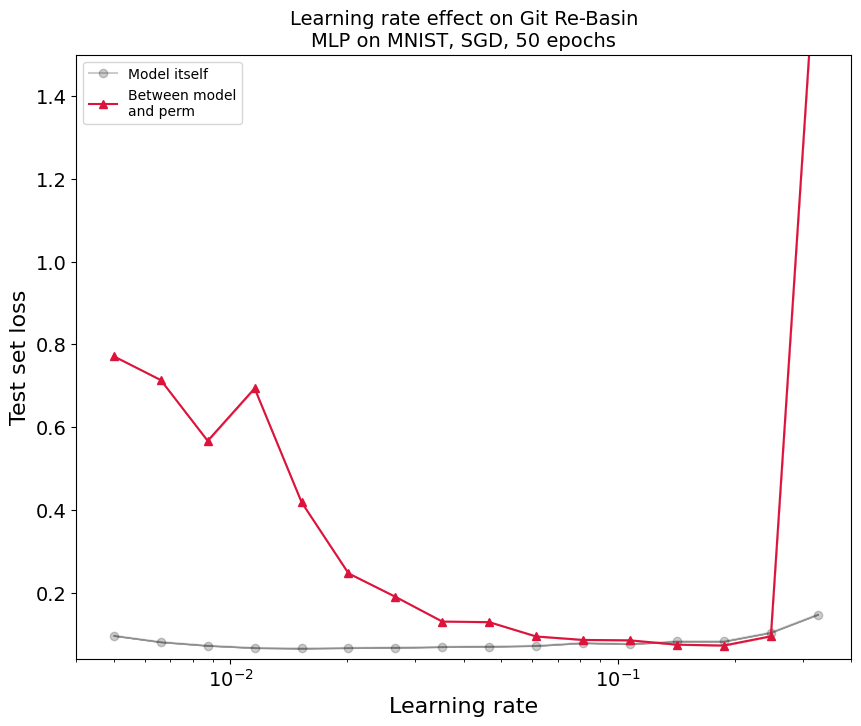

In [63]:

fig = plt.figure(figsize = (10, 8),dpi=100)
fig.patch.set_facecolor('white')
line_styles = ['solid','dashed','dotted']
plt.title(f"Learning rate effect on Git Re-Basin\nMLP on MNIST, SGD, {epochs} epochs",fontsize=14)
for i, stored_results_dict in enumerate(all_results):
  
  standard_bumps = np.array([d["bump_1_to_2"] for d in stored_results_dict])
  permuted_bumps = np.array([d["bump_1_to_2perm"] for d in stored_results_dict])
  model1_loss = np.array([d["model1_test_loss"] for d in stored_results_dict])
  model2_loss = np.array([d["model2_test_loss"] for d in stored_results_dict])
  
  standard_bumps = np.reshape(standard_bumps,[reps,-1])
  permuted_bumps = np.reshape(permuted_bumps,[reps,-1])
  model1_loss = np.reshape(model1_loss,[reps,-1])
  model2_loss = np.reshape(model2_loss,[reps,-1])
  
  def get_mean_and_error(vals):
    return np.mean(vals,axis=0), np.std(vals,axis=0)
  
  mean_standard_bumps, error_standard_bumps = get_mean_and_error(standard_bumps)
  mean_permuted_bumps, error_permuted_bumps = get_mean_and_error(permuted_bumps)
  mean_model1_loss, error_model1_loss = get_mean_and_error(model1_loss)
  mean_model2_loss, error_model2_loss = get_mean_and_error(model2_loss)
  skip_lrs = skipped_results[i]
  LRs_ = [lr for lr in LRs if lr not in skip_lrs]
  
  line, = plt.semilogx(LRs_[:len(mean_standard_bumps)],(mean_model1_loss+mean_model2_loss)/2.0,marker="o",alpha=0.2,color="black",linestyle=line_styles[i],label="Model itself")
  plt.fill_between(LRs_[:len(mean_standard_bumps)],
                   (mean_model1_loss+mean_model2_loss)/2.0-(error_model1_loss+error_model2_loss)/2.0,
                   (mean_model1_loss+mean_model2_loss)/2.0+(error_model1_loss+error_model2_loss)/2.0,
                   color=line.get_color(),
                   alpha=0.3
                   )
  
  #line, = plt.semilogx(LRs[:len(mean_standard_bumps)],mean_standard_bumps,marker="s",color="navy",linestyle=line_styles[i],label="Between models")
  #plt.fill_between(LRs[:len(mean_standard_bumps)],mean_standard_bumps-error_standard_bumps,mean_standard_bumps+error_standard_bumps,alpha=0.3,color=line.get_color())
  
  line, = plt.semilogx(LRs_[:len(mean_standard_bumps)],mean_permuted_bumps,marker="^",linestyle=line_styles[i],color="crimson",label="Between model\nand perm")
  plt.fill_between(LRs_[:len(mean_standard_bumps)],mean_permuted_bumps-error_permuted_bumps,mean_permuted_bumps+error_permuted_bumps,alpha=0.3,color=line.get_color())
  
  from matplotlib.patches import Rectangle
  
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((LRs[-3], 0.0),0.1,2.0, fill=True, color="green", alpha=0.3))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Learning rate",fontsize=16)
plt.ylabel("Test set loss",fontsize=16)
plt.ylim([0.04, 1.5])
plt.xlim([4e-3, 0.4])
plt.legend(fontsize=10)
plt.show()
  

## Adam Experimental sweep

In [65]:
reps = 1
LRs = np.exp(np.linspace(np.log(0.5*1e-4),np.log(0.01),20))
optimizers = ["adam"]
epochs = 50
fishers = [0.0] #, 0.5, 1.0]

In [66]:
all_results = []
all_flattened_models_tuples = []
for fisher in fishers:
    all_flattened_models_tuples = [] # collecting all solutions every
    stored_results_dict = []
    
    for rep in range(reps): # to get error bars
      for i_opt, optimizer in enumerate(optimizers):
        for i_LR, LR in enumerate(LRs):
    
          print("*****************************************")
          print(f"Experiment {len(stored_results_dict)} / {reps*len(optimizers)*len(LRs)}")
    
          flattened_models_list = get_optima(
              num_epochs = epochs,
              hessian = True,
              fisher_weight = fisher,
              config_optimizer = optimizer,
              learning_rate = LR,
              seed = int(np.random.rand()*100000000),
              )
          
          flattened_model1 = flattened_models_list[0]
          flattened_model2 = flattened_models_list[1]
          results_dict = analyze_optima(flattened_model1,flattened_model2)
    
          results_dict["LR"] = LR
          results_dict["optimizer"] = optimizer
          results_dict["epochs"] = epochs
          
          stored_results_dict.append(results_dict)
          all_flattened_models_tuples.append(flattened_models_list)
    
          print(results_dict)
    all_results.append(stored_results_dict)
    all_flattened_models_tuples.append(all_flattened_models_tuples)

*****************************************
Experiment 0 / 20
--------------------------
Starting run 0
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06949042528867722 test accuracy=0.9793000221252441 train loss=0.007906200364232063 train accuracy=0.9992499947547913
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06939489394426346 test accuracy=0.9790000319480896 train loss=0.008912105113267899 train accuracy=0.9989833235740662
0/P_0: 108.09320831298828
0/P_1: 62.03165817260742
0/P_2: 34.567176818847656
1/P_0: 11.334732055664062
1/P_2: 0.0
1/P_1: 5.0838775634765625
2/P_2: 7.117431640625
2/P_0: 3.19757080078125
2/P_1: 2.01947021484375
3/P_0: 1.835174560546875
3/P_1: 0.6035614013671875
3/P_2: 5.526641845703125
4/P_0: 0.8039703369140625
4/P_1: 0.8542938232421875
4/P_2: 1.9098358154296875
5/P_1: 0.2592010498046875
5/P_2: 1.351470947265625
5/P_0: 1.532135009765625
6/P_1: 0.308319091796875
6/P_2: 1.0562973022460938
6/P_0: 0.483001708984375
7/P_2: 0.0
7/P_1: 0.25537109375
7/P_0: 0.426971435546875
8/P_1: 0.020111083984375
8/P_0: 0.05084228515625
8/P_2: 1.34075927734375
9/P_0: 0.0
9/P_1: 0.175140380859375
9/P_2: 0.5792694091796875
10/P_2: 0.0
10/P_0: 0.1063690185546875
10/P_1: 0.0
11/P_0: 0.0
11/P_2: 0.0
11/P_1: 0.0
{'model1_test_loss': DeviceArray(0.06949

100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.08014918863773346 test accuracy=0.978100061416626 train loss=0.004326407797634602 train accuracy=0.9996166825294495
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.07098506391048431 test accuracy=0.9807000756263733 train loss=0.0029441858641803265 train accuracy=0.999916672706604
0/P_0: 113.20543670654297
0/P_1: 63.111663818359375
0/P_2: 36.34498596191406
1/P_0: 12.536537170410156
1/P_2: 0.0
1/P_1: 8.474090576171875
2/P_2: 9.816505432128906
2/P_0: 4.3877105712890625
2/P_1: 2.0225677490234375
3/P_0: 1.7559356689453125
3/P_1: 1.014251708984375
3/P_2: 5.9591827392578125
4/P_0: 0.8108673095703125
4/P_1: 1.715789794921875
4/P_2: 2.81024169921875
5/P_1: 0.3042144775390625
5/P_2: 1.3393707275390625
5/P_0: 0.98248291015625
6/P_1: 0.7483978271484375
6/P_2: 1.1068344116210938
6/P_0: 0.627593994140625
7/P_2: 0.0
7/P_1: 0.5480804443359375
7/P_0: 0.218170166015625
8/P_1: 0.211517333984375
8/P_0: 0.5418243408203125
8/P_2: 0.9527359008789062
9/P_0: 0.0
9/P_1: 0.07977294921875
9/P_2: 0.43018341064453125
10/P_2: 0.0
10/P_0: 0.3125457763671875
10/P_1: 0.0514373779296875
11/P_0: 0.0768585205078125
11/P_2: 0.2797851562

100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.08297193050384521 test accuracy=0.9801000356674194 train loss=0.0011299188481643796 train accuracy=0.9999833703041077
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.07861274480819702 test accuracy=0.9796000719070435 train loss=0.0012392514618113637 train accuracy=0.9999833703041077
0/P_0: 119.8873291015625
0/P_1: 63.44485855102539
0/P_2: 37.654109954833984
1/P_0: 15.0950927734375
1/P_2: 0.0
1/P_1: 9.390060424804688
2/P_2: 10.989509582519531
2/P_0: 3.9225006103515625
2/P_1: 5.01055908203125
3/P_0: 3.2188262939453125
3/P_1: 0.92401123046875
3/P_2: 8.513763427734375
4/P_0: 0.756927490234375
4/P_1: 2.101165771484375
4/P_2: 3.8708724975585938
5/P_1: 0.33306884765625
5/P_2: 1.419219970703125
5/P_0: 1.7891845703125
6/P_1: 0.856231689453125
6/P_2: 1.60894775390625
6/P_0: 0.9817962646484375
7/P_2: 0.0
7/P_1: 0.2525634765625
7/P_0: 0.2669525146484375
8/P_1: 0.0012969970703125
8/P_0: 0.0533905029296875
8/P_2: 0.7485733032226562
9/P_0: 0.0
9/P_1: 0.26739501953125
9/P_2: 0.6578903198242188
10/P_2: 0.0
10/P_0: 0.31317138671875
10/P_1: 0.1976776123046875
11/P_0: 0.273345947265625
11/P_2: 0.55169677734375
11/P_1: 0.

100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.08740204572677612 test accuracy=0.9794000387191772 train loss=0.00044332011020742357 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.60it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.08823370933532715 test accuracy=0.9813000559806824 train loss=0.0003880509757436812 train accuracy=1.0
0/P_0: 121.30401611328125
0/P_1: 71.38937377929688
0/P_2: 43.96678924560547
1/P_0: 12.666107177734375
1/P_2: 0.0
1/P_1: 10.4833984375
2/P_2: 12.305534362792969
2/P_0: 5.8426361083984375
2/P_1: 5.339752197265625
3/P_0: 3.29974365234375
3/P_1: 1.82476806640625
3/P_2: 10.20477294921875
4/P_0: 1.0229034423828125
4/P_1: 2.3139190673828125
4/P_2: 2.857635498046875
5/P_1: 0.610137939453125
5/P_2: 1.54156494140625
5/P_0: 2.2968292236328125
6/P_1: 0.841644287109375
6/P_2: 1.5333404541015625
6/P_0: 0.8144073486328125
7/P_2: 0.0
7/P_1: 0.1727294921875
7/P_0: 0.5126953125
8/P_1: 0.1230926513671875
8/P_0: 0.3671722412109375
8/P_2: 1.06170654296875
9/P_0: 0.0
9/P_1: 0.297271728515625
9/P_2: 0.63726806640625
10/P_2: 0.0
10/P_0: 0.251495361328125
10/P_1: 0.363311767578125
11/P_0: 0.2287139892578125
11/P_2: 0.4868621826171875
11/P_1: 0.2007293701171875
1

100%|██████████| 50/50 [00:13<00:00,  3.60it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.09131577610969543 test accuracy=0.9802000522613525 train loss=0.00017991561617236584 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.09202032536268234 test accuracy=0.9812000393867493 train loss=0.00015376409282907844 train accuracy=1.0
0/P_0: 120.66620635986328
0/P_1: 72.96387481689453
0/P_2: 44.58393859863281
1/P_0: 16.725677490234375
1/P_2: 0.0
1/P_1: 16.699462890625
2/P_2: 20.07872772216797
2/P_0: 6.5785369873046875
2/P_1: 7.0416717529296875
3/P_0: 3.33465576171875
3/P_1: 1.0036163330078125
3/P_2: 9.050750732421875
4/P_0: 0.9765472412109375
4/P_1: 1.6058197021484375
4/P_2: 2.62176513671875
5/P_1: 0.6699676513671875
5/P_2: 0.98895263671875
5/P_0: 1.6878814697265625
6/P_1: 0.826995849609375
6/P_2: 1.080169677734375
6/P_0: 0.59130859375
7/P_2: 0.0
7/P_1: 0.5869903564453125
7/P_0: 0.718109130859375
8/P_1: 0.1797637939453125
8/P_0: 0.240325927734375
8/P_2: 1.93896484375
9/P_0: 0.0
9/P_1: 0.581298828125
9/P_2: 0.8065948486328125
10/P_2: 0.0
10/P_0: 0.5046844482421875
10/P_1: 0.45794677734375
11/P_0: 0.2330322265625
11/P_2: 0.698150634765625
11/P_1: 0.0199737548828125
12/

100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.09678582847118378 test accuracy=0.9821000695228577 train loss=8.06278403615579e-05 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.09256139397621155 test accuracy=0.9825000762939453 train loss=8.166416228050366e-05 train accuracy=1.0
0/P_0: 132.61093139648438
0/P_1: 76.8415298461914
0/P_2: 50.6096305847168
1/P_0: 16.666366577148438
1/P_2: 0.0
1/P_1: 19.07696533203125
2/P_2: 17.456520080566406
2/P_0: 6.8872528076171875
2/P_1: 5.2817535400390625
3/P_0: 3.0643463134765625
3/P_1: 0.969268798828125
3/P_2: 8.85662841796875
4/P_0: 1.586212158203125
4/P_1: 1.986328125
4/P_2: 2.6161041259765625
5/P_1: 0.7871551513671875
5/P_2: 1.4422760009765625
5/P_0: 1.82012939453125
6/P_1: 0.6863861083984375
6/P_2: 1.588287353515625
6/P_0: 0.6581268310546875
7/P_2: 0.0
7/P_1: 0.2596435546875
7/P_0: 0.4521331787109375
8/P_1: 0.200408935546875
8/P_0: 0.24737548828125
8/P_2: 1.5452423095703125
9/P_0: 0.0
9/P_1: 0.2767333984375
9/P_2: 0.66888427734375
10/P_2: 0.0
10/P_0: 0.2968292236328125
10/P_1: 0.2147216796875
11/P_0: 0.401275634765625
11/P_2: 0.9404449462890625
11/P_1: 0.1407470703125
12/P

100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.110418900847435 test accuracy=0.9810000658035278 train loss=4.746290505863726e-05 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.09918112307786942 test accuracy=0.9833000302314758 train loss=3.681271118693985e-05 train accuracy=1.0
0/P_0: 137.91314697265625
0/P_1: 77.4887924194336
0/P_2: 55.379844665527344
1/P_0: 14.7850341796875
1/P_2: 0.0
1/P_1: 17.17181396484375
2/P_2: 16.535400390625
2/P_0: 5.976531982421875
2/P_1: 6.7721405029296875
3/P_0: 3.072021484375
3/P_1: 1.6428985595703125
3/P_2: 10.560409545898438
4/P_0: 1.25042724609375
4/P_1: 2.7280426025390625
4/P_2: 4.6409759521484375
5/P_1: 0.81536865234375
5/P_2: 1.5023651123046875
5/P_0: 1.7723846435546875
6/P_1: 0.992523193359375
6/P_2: 1.969329833984375
6/P_0: 0.83709716796875
7/P_2: 0.0
7/P_1: 0.381256103515625
7/P_0: 0.631103515625
8/P_1: 0.131439208984375
8/P_0: 0.304046630859375
8/P_2: 1.1275177001953125
9/P_0: 0.0
9/P_1: 0.1495361328125
9/P_2: 0.4151763916015625
10/P_2: 0.0
10/P_0: 0.3693695068359375
10/P_1: 0.105743408203125
11/P_0: 0.1189727783203125
11/P_2: 0.2142791748046875
11/P_1: 0.0
12/P_0: 0.0
12

100%|██████████| 50/50 [00:13<00:00,  3.61it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.10120274871587753 test accuracy=0.9823000431060791 train loss=2.3026655981084332e-05 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.10402195155620575 test accuracy=0.9826000332832336 train loss=1.9904466171283275e-05 train accuracy=1.0
0/P_0: 141.8876495361328
0/P_1: 89.14305877685547
0/P_2: 55.227210998535156
1/P_0: 17.511444091796875
1/P_2: 0.0
1/P_1: 21.938796997070312
2/P_2: 20.127349853515625
2/P_0: 6.733062744140625
2/P_1: 5.531005859375
3/P_0: 2.9869842529296875
3/P_1: 1.22418212890625
3/P_2: 7.5421600341796875
4/P_0: 0.6695556640625
4/P_1: 1.112640380859375
4/P_2: 1.59228515625
5/P_1: 0.63238525390625
5/P_2: 0.7682342529296875
5/P_0: 1.12554931640625
6/P_1: 0.5186767578125
6/P_2: 1.3255157470703125
6/P_0: 0.591461181640625
7/P_2: 0.0
7/P_1: 0.923919677734375
7/P_0: 0.641204833984375
8/P_1: 0.17938232421875
8/P_0: 0.155029296875
8/P_2: 2.124298095703125
9/P_0: 0.0
9/P_1: 0.47216796875
9/P_2: 0.59613037109375
10/P_2: 0.0
10/P_0: 0.408660888671875
10/P_1: 0.05279541015625
11/P_0: 0.1121826171875
11/P_2: 0.503814697265625
11/P_1: 0.002471923828125
12/P_0: 0.095046

100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.09638656675815582 test accuracy=0.9828000664710999 train loss=1.3537211998482235e-05 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.09468767791986465 test accuracy=0.9844000339508057 train loss=1.1385947800590657e-05 train accuracy=1.0
0/P_0: 167.2279052734375
0/P_1: 108.43136596679688
0/P_2: 68.98198699951172
1/P_0: 18.085357666015625
1/P_2: 0.0
1/P_1: 25.07232666015625
2/P_2: 19.633697509765625
2/P_0: 5.46502685546875
2/P_1: 5.38348388671875
3/P_0: 2.172119140625
3/P_1: 0.93603515625
3/P_2: 7.44500732421875
4/P_0: 0.655792236328125
4/P_1: 1.438720703125
4/P_2: 2.86358642578125
5/P_1: 0.286285400390625
5/P_2: 0.9200286865234375
5/P_0: 1.57318115234375
6/P_1: 0.42718505859375
6/P_2: 1.443450927734375
6/P_0: 0.586395263671875
7/P_2: 0.0
7/P_1: 0.12353515625
7/P_0: 0.2022705078125
8/P_1: 0.060882568359375
8/P_0: 0.208160400390625
8/P_2: 0.6847381591796875
9/P_0: 0.0
9/P_1: 0.1190185546875
9/P_2: 0.366607666015625
10/P_2: 0.0
10/P_0: 0.12640380859375
10/P_1: 0.1209716796875
11/P_0: 0.22003173828125
11/P_2: 0.1646881103515625
11/P_1: 0.014373779296875
12/P_0: 0.0189208984

100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.09667515754699707 test accuracy=0.9848000407218933 train loss=7.638229362783022e-06 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.0886804386973381 test accuracy=0.9864000678062439 train loss=5.729841632273747e-06 train accuracy=1.0
0/P_0: 199.19935607910156
0/P_1: 124.82914733886719
0/P_2: 77.21955871582031
1/P_0: 20.465301513671875
1/P_2: 0.0
1/P_1: 25.687301635742188
2/P_2: 21.841598510742188
2/P_0: 5.46795654296875
2/P_1: 5.8858642578125
3/P_0: 1.65875244140625
3/P_1: 1.156005859375
3/P_2: 5.850128173828125
4/P_0: 0.8641357421875
4/P_1: 1.1168212890625
4/P_2: 2.0124053955078125
5/P_1: 0.34075927734375
5/P_2: 0.859161376953125
5/P_0: 0.81256103515625
6/P_1: 0.30224609375
6/P_2: 0.8607635498046875
6/P_0: 0.609283447265625
7/P_2: 0.0
7/P_1: 0.298675537109375
7/P_0: 0.242919921875
8/P_1: 0.092742919921875
8/P_0: 0.19696044921875
8/P_2: 0.9197540283203125
9/P_0: 0.0
9/P_1: 0.060333251953125
9/P_2: 0.11700439453125
10/P_2: 0.0
10/P_0: 0.029449462890625
10/P_1: 0.081878662109375
11/P_0: 0.0386962890625
11/P_2: 0.0716094970703125
11/P_1: 0.065277099609375
12/P_0: 0.00512

100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.09199605882167816 test accuracy=0.983500063419342 train loss=0.0013585228007286787 train accuracy=0.9997166991233826
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.11707848310470581 test accuracy=0.9806000590324402 train loss=0.007319610565900803 train accuracy=0.9979833364486694
0/P_0: 467.6596374511719
0/P_1: 251.86976623535156
0/P_2: 167.91488647460938
1/P_0: 19.8599853515625
1/P_2: 0.0
1/P_1: 44.10760498046875
2/P_2: 24.861419677734375
2/P_0: 5.70819091796875
2/P_1: 5.9715576171875
3/P_0: 1.6768798828125
3/P_1: 0.78253173828125
3/P_2: 7.54351806640625
4/P_0: 0.36883544921875
4/P_1: 1.8260498046875
4/P_2: 2.811553955078125
5/P_1: 0.64154052734375
5/P_2: 0.801849365234375
5/P_0: 0.683349609375
6/P_1: 0.2991943359375
6/P_2: 0.67938232421875
6/P_0: 0.019775390625
7/P_2: 0.0
7/P_1: 0.0426025390625
7/P_0: 0.0062255859375
8/P_1: 0.048583984375
8/P_0: 0.002197265625
8/P_2: 0.0318603515625
9/P_0: 0.0
9/P_1: 0.017578125
9/P_2: 0.13592529296875
10/P_2: 0.0
10/P_0: 0.00518798828125
10/P_1: 0.07080078125
11/P_0: 0.12078857421875
11/P_2: 0.68524169921875
11/P_1: 0.0322265625
12/P_0: 0.00323486328125
12/P_1: 0

100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.09142429381608963 test accuracy=0.9867000579833984 train loss=1.163087654276751e-05 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.09807135164737701 test accuracy=0.9819000363349915 train loss=0.0041821664199233055 train accuracy=0.9988499879837036
0/P_0: 662.226806640625
0/P_1: 330.46990966796875
0/P_2: 205.1141815185547
1/P_0: 30.9603271484375
1/P_2: 0.0
1/P_1: 62.71380615234375
2/P_2: 32.817626953125
2/P_0: 5.898681640625
2/P_1: 6.48388671875
3/P_0: 1.294189453125
3/P_1: 1.02996826171875
3/P_2: 6.5037841796875
4/P_0: 0.5264892578125
4/P_1: 0.371337890625
4/P_2: 1.387908935546875
5/P_1: 0.1923828125
5/P_2: 0.462493896484375
5/P_0: 0.395751953125
6/P_1: 0.2044677734375
6/P_2: 0.318145751953125
6/P_0: 0.234619140625
7/P_2: 0.0
7/P_1: 0.2193603515625
7/P_0: 0.0369873046875
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.35052490234375
9/P_0: 0.0
9/P_1: 0.05694580078125
9/P_2: 0.16973876953125
10/P_2: 0.0
10/P_0: 0.04248046875
10/P_1: 0.018310546875
11/P_0: 0.0
11/P_2: 0.18951416015625
11/P_1: 0.01953125
12/P_0: 0.0
12/P_1: 0.0
12/P_2: 0.03692626953125
13/P_2: 0.0
13/P_1: 0.03002929687

100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.10853803902864456 test accuracy=0.9818000197410583 train loss=0.0032243349123746157 train accuracy=0.9990333318710327
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.10780199617147446 test accuracy=0.9821000695228577 train loss=0.00611078692600131 train accuracy=0.9980500340461731
0/P_0: 1083.6656494140625
0/P_1: 492.3621520996094
0/P_2: 279.92254638671875
1/P_0: 25.265625
1/P_2: 0.0
1/P_1: 62.12921142578125
2/P_2: 29.68865966796875
2/P_0: 6.5208740234375
2/P_1: 4.052490234375
3/P_0: 0.4832763671875
3/P_1: 0.530517578125
3/P_2: 3.73333740234375
4/P_0: 0.07275390625
4/P_1: 0.9268798828125
4/P_2: 1.51263427734375
5/P_1: 0.032470703125
5/P_2: 0.05792236328125
5/P_0: 0.277587890625
6/P_1: 0.12353515625
6/P_2: 0.059173583984375
6/P_0: 0.0
7/P_2: 0.0
7/P_1: 0.0068359375
7/P_0: 0.0
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.3045654296875
9/P_0: 0.0
9/P_1: 0.1612548828125
9/P_2: 0.379486083984375
10/P_2: 0.0
10/P_0: 0.1683349609375
10/P_1: 0.15771484375
11/P_0: 0.0
11/P_2: 0.53350830078125
11/P_1: 0.0380859375
12/P_0: 0.0
12/P_1: 0.0
12/P_2: 0.0599365234375
13/P_2: 0.0
13/P_1: 0.0
13/P_0: 0.0
{'model1_test_loss': DeviceA

100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.09705235809087753 test accuracy=0.9838000535964966 train loss=0.002204085001721978 train accuracy=0.9993667006492615
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.1427229344844818 test accuracy=0.9788000583648682 train loss=0.008436301723122597 train accuracy=0.9980166554450989
0/P_0: 1702.14453125
0/P_1: 703.8469848632812
0/P_2: 349.255615234375
1/P_0: 28.68359375
1/P_2: 0.0
1/P_1: 78.93310546875
2/P_2: 44.56304931640625
2/P_0: 5.00732421875
2/P_1: 6.38916015625
3/P_0: 1.03271484375
3/P_1: 0.54345703125
3/P_2: 7.0572509765625
4/P_0: 0.498046875
4/P_1: 1.5965576171875
4/P_2: 2.050537109375
5/P_1: 0.2342529296875
5/P_2: 0.65008544921875
5/P_0: 0.622314453125
6/P_1: 0.44873046875
6/P_2: 1.40484619140625
6/P_0: 0.051025390625
7/P_2: 0.0
7/P_1: 0.0831298828125
7/P_0: 0.0
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.07965087890625
9/P_0: 0.0
9/P_1: 0.052978515625
9/P_2: 0.09228515625
10/P_2: 0.0
10/P_0: 0.0224609375
10/P_1: 0.2918701171875
11/P_0: 0.060791015625
11/P_2: 0.17620849609375
11/P_1: 0.34521484375
12/P_0: 0.0
12/P_1: 0.0
12/P_2: 0.3807373046875
13/P_2: 0.0
13/P_1: 0.01953125
13/P_0: 0.035400390625
14/P_0: 

100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.10279805213212967 test accuracy=0.98170006275177 train loss=0.006399717181921005 train accuracy=0.9980999827384949
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.10956905037164688 test accuracy=0.9803000688552856 train loss=0.009023834019899368 train accuracy=0.9973999857902527
0/P_0: 2605.89501953125
0/P_1: 1072.16064453125
0/P_2: 438.77459716796875
1/P_0: 35.072021484375
1/P_2: 0.0
1/P_1: 82.99365234375
2/P_2: 51.3636474609375
2/P_0: 3.13525390625
2/P_1: 5.865478515625
3/P_0: 2.420654296875
3/P_1: 1.228759765625
3/P_2: 12.7073974609375
4/P_0: 0.997802734375
4/P_1: 1.729248046875
4/P_2: 3.1256103515625
5/P_1: 0.522705078125
5/P_2: 2.1080322265625
5/P_0: 0.90673828125
6/P_1: 0.5498046875
6/P_2: 2.2603759765625
6/P_0: 0.090576171875
7/P_2: 0.0
7/P_1: 0.839111328125
7/P_0: 0.42578125
8/P_1: 0.096435546875
8/P_0: 0.00830078125
8/P_2: 1.1890869140625
9/P_0: 0.0
9/P_1: 0.1806640625
9/P_2: 1.248779296875
10/P_2: 0.0
10/P_0: 0.10498046875
10/P_1: 0.68017578125
11/P_0: 0.00146484375
11/P_2: 1.6689453125
11/P_1: 0.41748046875
12/P_0: 0.08349609375
12/P_1: 0.0
12/P_2: 0.7012939453125
13/P_2: 0.0
13/P_1: 0.2

100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.14541499316692352 test accuracy=0.9808000326156616 train loss=0.003978509921580553 train accuracy=0.9992499947547913
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.12331841140985489 test accuracy=0.982200026512146 train loss=0.004125318489968777 train accuracy=0.9988000392913818
0/P_0: 4257.833984375
0/P_1: 1657.2584228515625
0/P_2: 579.206298828125
1/P_0: 28.6005859375
1/P_2: 0.0
1/P_1: 50.28271484375
2/P_2: 45.617431640625
2/P_0: 3.5185546875
2/P_1: 11.30517578125
3/P_0: 3.673828125
3/P_1: 3.61572265625
3/P_2: 28.6551513671875
4/P_0: 0.30810546875
4/P_1: 6.215087890625
4/P_2: 12.083740234375
5/P_1: 1.612060546875
5/P_2: 3.98291015625
5/P_0: 1.22998046875
6/P_1: 0.277587890625
6/P_2: 1.3369140625
6/P_0: 0.087890625
7/P_2: 0.0
7/P_1: 0.679443359375
7/P_0: 0.3466796875
8/P_1: 0.02880859375
8/P_0: 0.07080078125
8/P_2: 2.6463623046875
9/P_0: 0.0
9/P_1: 0.194091796875
9/P_2: 0.0794677734375
10/P_2: 0.0
10/P_0: 0.0185546875
10/P_1: 0.0
11/P_0: 0.0
11/P_2: 0.0
11/P_1: 0.0
{'model1_test_loss': DeviceArray(0.145415, dtype=float32), 'model2_test_loss': DeviceArray(0.12331841, dtype=float32), 'model2_permuted

100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.1482275128364563 test accuracy=0.9802000522613525 train loss=0.0063336133025586605 train accuracy=0.9987166523933411
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.13770389556884766 test accuracy=0.9814000725746155 train loss=0.007676213514059782 train accuracy=0.9980000257492065
0/P_0: 6899.798828125
0/P_1: 2535.102294921875
0/P_2: 736.044677734375
1/P_0: 51.7744140625
1/P_2: 0.0
1/P_1: 56.296875
2/P_2: 59.517578125
2/P_0: 6.9013671875
2/P_1: 9.9775390625
3/P_0: 3.6171875
3/P_1: 1.255859375
3/P_2: 23.8857421875
4/P_0: 1.62109375
4/P_1: 5.13134765625
4/P_2: 11.7587890625
5/P_1: 1.33544921875
5/P_2: 1.8154296875
5/P_0: 1.01171875
6/P_1: 1.4892578125
6/P_2: 5.689453125
6/P_0: 0.37109375
7/P_2: 0.0
7/P_1: 0.34716796875
7/P_0: 0.5517578125
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 2.16650390625
9/P_0: 0.0
9/P_1: 0.185546875
9/P_2: 0.303955078125
10/P_2: 0.0
10/P_0: 0.0126953125
10/P_1: 0.5595703125
11/P_0: 0.119140625
11/P_2: 2.20849609375
11/P_1: 1.4365234375
12/P_0: 0.1689453125
12/P_1: 0.021484375
12/P_2: 2.869140625
13/P_2: 0.0
13/P_1: 0.28271484375
13/P_0: 0.177734375
14/P_0: 0.0
14/P_2: 1.19873046875
14/P_1: 0

100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.1500060111284256 test accuracy=0.9798000454902649 train loss=0.009662805125117302 train accuracy=0.997783362865448
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.15342247486114502 test accuracy=0.9808000326156616 train loss=0.007288291584700346 train accuracy=0.9982500076293945
0/P_0: 9662.1318359375
0/P_1: 3198.59228515625
0/P_2: 869.802978515625
1/P_0: 49.5703125
1/P_2: 0.0
1/P_1: 63.98095703125
2/P_2: 82.203125
2/P_0: 7.177734375
2/P_1: 6.28173828125
3/P_0: 2.9599609375
3/P_1: 0.865234375
3/P_2: 24.4365234375
4/P_0: 0.5146484375
4/P_1: 2.0751953125
4/P_2: 10.852294921875
5/P_1: 3.142578125
5/P_2: 3.88525390625
5/P_0: 1.943359375
6/P_1: 0.931640625
6/P_2: 0.677001953125
6/P_0: 0.271484375
7/P_2: 0.0
7/P_1: 0.48388671875
7/P_0: 0.4140625
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.84033203125
9/P_0: 0.0
9/P_1: 0.5634765625
9/P_2: 1.189453125
10/P_2: 0.0
10/P_0: 0.265625
10/P_1: 0.3173828125
11/P_0: 0.35546875
11/P_2: 0.72900390625
11/P_1: 0.0
12/P_0: 0.0
12/P_1: 0.0
12/P_2: 0.0
{'model1_test_loss': DeviceArray(0.15000601, dtype=float32), 'model2_test_loss': DeviceArray(0.15342247, dtype=float32), 'model2_perm

100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.1982036530971527 test accuracy=0.9770000576972961 train loss=0.02603367529809475 train accuracy=0.9945833683013916
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.18913890421390533 test accuracy=0.9810000658035278 train loss=0.005274010356515646 train accuracy=0.9986333250999451
0/P_0: 10780.61328125
0/P_1: 4169.6064453125
0/P_2: 1159.0703125
1/P_0: 51.474609375
1/P_2: 0.0
1/P_1: 84.9765625
2/P_2: 55.9130859375
2/P_0: 10.30859375
2/P_1: 22.025390625
3/P_0: 5.4677734375
3/P_1: 0.40234375
3/P_2: 22.3486328125
4/P_0: 0.603515625
4/P_1: 2.765625
4/P_2: 7.861328125
5/P_1: 1.3896484375
5/P_2: 0.8095703125
5/P_0: 2.291015625
6/P_1: 0.306640625
6/P_2: 0.28076171875
6/P_0: 0.9208984375
7/P_2: 0.0
7/P_1: 0.0
7/P_0: 0.0
{'model1_test_loss': DeviceArray(0.19820365, dtype=float32), 'model2_test_loss': DeviceArray(0.1891389, dtype=float32), 'model2_permuted_test_loss': DeviceArray(0.18913892, dtype=float32), 'bump_1_to_2': DeviceArray(2.0803227, dtype=float32), 'bump_1_to_2perm': DeviceArray(0.147608, dtype=float32), 'bump_2_to_2perm': DeviceArray(2.0296137, dtype=float32), 'LR': 0.0075664672755894275, 'optimize

100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.24306733906269073 test accuracy=0.9771000742912292 train loss=0.013097715564072132 train accuracy=0.9970666766166687
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.22241881489753723 test accuracy=0.976300060749054 train loss=0.019506707787513733 train accuracy=0.9946666955947876
0/P_0: 10366.4423828125
0/P_1: 5209.2744140625
0/P_2: 1513.23291015625
1/P_0: 58.486328125
1/P_2: 0.0
1/P_1: 95.705078125
2/P_2: 65.15625
2/P_0: 12.607421875
2/P_1: 28.685546875
3/P_0: 5.712890625
3/P_1: 0.388671875
3/P_2: 9.7607421875
4/P_0: 0.896484375
4/P_1: 4.3173828125
4/P_2: 1.8935546875
5/P_1: 1.427734375
5/P_2: 1.60791015625
5/P_0: 3.126953125
6/P_1: 2.03125
6/P_2: 3.82080078125
6/P_0: 1.759765625
7/P_2: 0.0
7/P_1: 0.47265625
7/P_0: 1.3486328125
8/P_1: 0.2099609375
8/P_0: 0.400390625
8/P_2: 3.72607421875
9/P_0: 0.0
9/P_1: 0.748046875
9/P_2: 0.3837890625
10/P_2: 0.0
10/P_0: 2.1201171875
10/P_1: 0.4140625
11/P_0: 0.228515625
11/P_2: 0.021484375
11/P_1: 0.2099609375
12/P_0: 0.578125
12/P_1: 0.0009765625
12/P_2: 0.486328125
13/P_2: 0.0
13/P_1: 0.158203125
13/P_0: 0.056640625
14/P_0: 0.0
14/P_2: 0.0
14/P_1: 0.0
{'model1_t

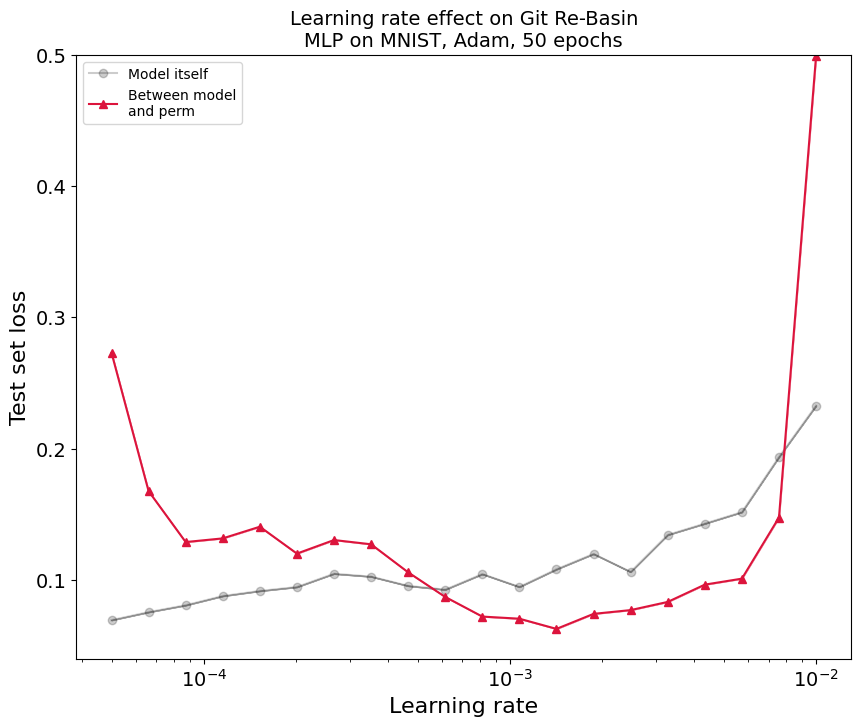

In [69]:
fig = plt.figure(figsize = (10, 8),dpi=100)
fig.patch.set_facecolor('white')

plt.title(f"Learning rate effect on Git Re-Basin\nMLP on MNIST, Adam, {epochs} epochs",fontsize=14)
line_styles = ["solid", "dashed", "dotted"]
for i, stored_results_dict in enumerate(all_results):
  standard_bumps = np.array([d["bump_1_to_2"] for d in stored_results_dict])
  permuted_bumps = np.array([d["bump_1_to_2perm"] for d in stored_results_dict])
  model1_loss = np.array([d["model1_test_loss"] for d in stored_results_dict])
  model2_loss = np.array([d["model2_test_loss"] for d in stored_results_dict])
  
  standard_bumps = np.reshape(standard_bumps,[reps,-1])
  permuted_bumps = np.reshape(permuted_bumps,[reps,-1])
  model1_loss = np.reshape(model1_loss,[reps,-1])
  model2_loss = np.reshape(model2_loss,[reps,-1])
  
  def get_mean_and_error(vals):
    return np.mean(vals,axis=0), np.std(vals,axis=0)
  
  mean_standard_bumps, error_standard_bumps = get_mean_and_error(standard_bumps)
  mean_permuted_bumps, error_permuted_bumps = get_mean_and_error(permuted_bumps)    
  mean_model1_loss, error_model1_loss = get_mean_and_error(model1_loss)
  mean_model2_loss, error_model2_loss = get_mean_and_error(model2_loss)
  
  
  line, = plt.semilogx(LRs[:len(mean_standard_bumps)],(mean_model1_loss+mean_model2_loss)/2.0,marker="o",alpha=0.2,color="black",linestyle=line_styles[i],label="Model itself")
  plt.fill_between(LRs[:len(mean_standard_bumps)],
                   (mean_model1_loss+mean_model2_loss)/2.0-(error_model1_loss+error_model2_loss)/2.0,
                   (mean_model1_loss+mean_model2_loss)/2.0+(error_model1_loss+error_model2_loss)/2.0,
                   color=line.get_color(),
                   alpha=0.3
                   )
  
  #line, = plt.semilogx(LRs[:len(mean_standard_bumps)],mean_standard_bumps,marker="s",color="navy",label="Between models",linestyle=line_styles[i])
  #plt.fill_between(LRs[:len(mean_standard_bumps)],mean_standard_bumps-error_standard_bumps,mean_standard_bumps+error_standard_bumps,alpha=0.3,color=line.get_color())
  
  line, = plt.semilogx(LRs[:len(mean_standard_bumps)],mean_permuted_bumps,marker="^",color="crimson",label="Between model\nand perm",linestyle=line_styles[i])
  plt.fill_between(LRs[:len(mean_standard_bumps)],mean_permuted_bumps-error_permuted_bumps,mean_permuted_bumps+error_permuted_bumps,alpha=0.3,color=line.get_color())
  
from matplotlib.patches import Rectangle
currentAxis = plt.gca()
#currentAxis.add_patch(Rectangle((LRs[0], 0.0),LRs[3]-LRs[0],3.0, fill=True, color="green", alpha=0.3))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Learning rate",fontsize=16)
plt.ylabel("Test set loss",fontsize=16)
plt.ylim([0.04,0.5])

plt.legend(fontsize=10)
plt.show()
  

## AdamW Experimental sweep

In [25]:
reps = 1
LRs = np.exp(np.linspace(np.log(0.5*1e-4),np.log(0.01),10))
optimizers = ["adamw"]
epochs = 50
fishers = [0.0, 0.5, 1.0]

In [32]:
all_results = []
all_flattened_models_tuples = []
for fisher in fishers:
    all_flattened_models_tuples = [] # collecting all solutions every
    stored_results_dict = []
    
    for rep in range(reps): # to get error bars
      for i_opt, optimizer in enumerate(optimizers):
        for i_LR, LR in enumerate(LRs):
    
          print("*****************************************")
          print(f"Experiment {len(stored_results_dict)} / {reps*len(optimizers)*len(LRs)}")
          # stuff = make_stuff(model) 
          flattened_models_list = get_optima(
              num_epochs = epochs,
              hessian = True,
              fisher_weight = fisher,
              config_optimizer = optimizer,
              learning_rate = LR,
              seed = int(np.random.rand()*100000000),
              )
          
          flattened_model1 = flattened_models_list[0]
          flattened_model2 = flattened_models_list[1]
          results_dict = analyze_optima(flattened_model1,flattened_model2)
    
          results_dict["LR"] = LR
          results_dict["optimizer"] = optimizer
          results_dict["epochs"] = epochs
          
          stored_results_dict.append(results_dict)
          all_flattened_models_tuples.append(flattened_models_list)
    
          print(results_dict)
    all_results.append(stored_results_dict)
    all_flattened_models_tuples.append(all_flattened_models_tuples)

*****************************************
Experiment 0 / 10
--------------------------
Starting run 0
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:14<00:00,  3.54it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06809275597333908 test accuracy=0.9798000454902649 train loss=0.010424408130347729 train accuracy=0.9986000061035156
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:14<00:00,  3.49it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06488817185163498 test accuracy=0.98170006275177 train loss=0.011201458983123302 train accuracy=0.9983333349227905
0/P_0: 96.7490234375
0/P_1: 56.48534393310547
0/P_2: 32.36408233642578
1/P_0: 9.99798583984375
1/P_2: 0.0
1/P_1: 6.733917236328125
2/P_2: 8.620323181152344
2/P_0: 4.2385406494140625
2/P_1: 3.35675048828125
3/P_0: 1.6377105712890625
3/P_1: 0.5166168212890625
3/P_2: 6.237556457519531
4/P_0: 0.6788482666015625
4/P_1: 0.9500732421875
4/P_2: 1.7786865234375
5/P_1: 0.2796173095703125
5/P_2: 0.6346054077148438
5/P_0: 1.1745758056640625
6/P_1: 0.4233551025390625
6/P_2: 0.7821426391601562
6/P_0: 0.510162353515625
7/P_2: 0.0
7/P_1: 0.4895477294921875
7/P_0: 0.3547821044921875
8/P_1: 0.3292694091796875
8/P_0: 0.353515625
8/P_2: 1.0071640014648438
9/P_0: 0.0
9/P_1: 0.149017333984375
9/P_2: 0.3178863525390625
10/P_2: 0.0
10/P_0: 0.11712646484375
10/P_1: 0.130706787109375
11/P_0: 0.1913604736328125
11/P_2: 0.6271514892578125
11/P_1: 0.1255

100%|██████████| 50/50 [00:14<00:00,  3.54it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07143106311559677 test accuracy=0.9807000756263733 train loss=0.0024341465905308723 train accuracy=0.9999333620071411
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.07525210827589035 test accuracy=0.9795000553131104 train loss=0.001995382597669959 train accuracy=0.9999833703041077
0/P_0: 95.33158874511719
0/P_1: 60.26731872558594
0/P_2: 36.10512161254883
1/P_0: 11.621726989746094
1/P_2: 0.0
1/P_1: 12.423553466796875
2/P_2: 14.355384826660156
2/P_0: 4.83087158203125
2/P_1: 6.216644287109375
3/P_0: 3.6190032958984375
3/P_1: 1.3641815185546875
3/P_2: 7.2994384765625
4/P_0: 1.195831298828125
4/P_1: 1.3750152587890625
4/P_2: 1.6995086669921875
5/P_1: 0.642791748046875
5/P_2: 1.1752243041992188
5/P_0: 1.2965087890625
6/P_1: 0.403717041015625
6/P_2: 0.8854141235351562
6/P_0: 0.5498199462890625
7/P_2: 0.0
7/P_1: 0.40020751953125
7/P_0: 0.507476806640625
8/P_1: 0.14874267578125
8/P_0: 0.2486419677734375
8/P_2: 1.5072784423828125
9/P_0: 0.0
9/P_1: 0.2764129638671875
9/P_2: 0.8025131225585938
10/P_2: 0.0
10/P_0: 0.5439453125
10/P_1: 0.442962646484375
11/P_0: 0.42950439453125
11/P_2: 0.572265625
11/P_1: 0.096588

100%|██████████| 50/50 [00:14<00:00,  3.55it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07226782292127609 test accuracy=0.9823000431060791 train loss=0.0005035695503465831 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.07223770022392273 test accuracy=0.9821000695228577 train loss=0.0006512518739327788 train accuracy=1.0
0/P_0: 93.9892807006836
0/P_1: 68.12150573730469
0/P_2: 51.452369689941406
1/P_0: 13.488113403320312
1/P_2: 0.0
1/P_1: 31.717605590820312
2/P_2: 20.856735229492188
2/P_0: 5.6888275146484375
2/P_1: 5.73974609375
3/P_0: 1.791168212890625
3/P_1: 0.812530517578125
3/P_2: 4.6963348388671875
4/P_0: 0.579681396484375
4/P_1: 0.944671630859375
4/P_2: 1.2211456298828125
5/P_1: 0.1854095458984375
5/P_2: 0.3493804931640625
5/P_0: 1.110504150390625
6/P_1: 0.1570587158203125
6/P_2: 0.17669677734375
6/P_0: 0.2045440673828125
7/P_2: 0.0
7/P_1: 0.17254638671875
7/P_0: 0.14227294921875
8/P_1: 0.0592498779296875
8/P_0: 0.0337066650390625
8/P_2: 0.4296722412109375
9/P_0: 0.0
9/P_1: 0.0210113525390625
9/P_2: 0.1473388671875
10/P_2: 0.0
10/P_0: 0.115936279296875
10/P_1: 0.0101318359375
11/P_0: 0.0113677978515625
11/P_2: 0.0128021240234375
11/P_1: 0.0094146728

100%|██████████| 50/50 [00:13<00:00,  3.58it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06957627087831497 test accuracy=0.9838000535964966 train loss=0.0004204927827231586 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.07131040841341019 test accuracy=0.9830000400543213 train loss=0.0003335984656587243 train accuracy=1.0
0/P_0: 94.80009460449219
0/P_1: 73.64952087402344
0/P_2: 74.30165100097656
1/P_0: 11.61895751953125
1/P_2: 0.0
1/P_1: 36.202667236328125
2/P_2: 14.192138671875
2/P_0: 4.768310546875
2/P_1: 2.9917449951171875
3/P_0: 1.031036376953125
3/P_1: 0.4495849609375
3/P_2: 1.7120208740234375
4/P_0: 0.159515380859375
4/P_1: 0.39666748046875
4/P_2: 0.4356842041015625
5/P_1: 0.13336181640625
5/P_2: 0.394775390625
5/P_0: 0.376312255859375
6/P_1: 0.12890625
6/P_2: 0.1831817626953125
6/P_0: 0.07476806640625
7/P_2: 0.0
7/P_1: 0.091705322265625
7/P_0: 0.057220458984375
8/P_1: 0.0158843994140625
8/P_0: 0.023193359375
8/P_2: 0.153900146484375
9/P_0: 0.0
9/P_1: 0.0048828125
9/P_2: 0.0371551513671875
10/P_2: 0.0
10/P_0: 0.084136962890625
10/P_1: 0.011199951171875
11/P_0: 0.02490234375
11/P_2: 0.047637939453125
11/P_1: 0.0
12/P_0: 0.0
12/P_1: 0.0
12/P_2: 0.0
{'

100%|██████████| 50/50 [00:13<00:00,  3.60it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06614895164966583 test accuracy=0.9838000535964966 train loss=0.0002065126464003697 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.059126246720552444 test accuracy=0.9849000573158264 train loss=0.00024875649251043797 train accuracy=1.0
0/P_0: 88.21421813964844
0/P_1: 77.57703399658203
0/P_2: 91.9063949584961
1/P_0: 12.9110107421875
1/P_2: 0.0
1/P_1: 30.291366577148438
2/P_2: 6.235504150390625
2/P_0: 1.735748291015625
2/P_1: 1.341278076171875
3/P_0: 0.335113525390625
3/P_1: 0.160003662109375
3/P_2: 0.83819580078125
4/P_0: 0.084930419921875
4/P_1: 0.141510009765625
4/P_2: 0.121429443359375
5/P_1: 0.0987548828125
5/P_2: 0.0687103271484375
5/P_0: 0.136627197265625
6/P_1: 0.085418701171875
6/P_2: 0.0337677001953125
6/P_0: 0.0192108154296875
7/P_2: 0.0
7/P_1: 0.001708984375
7/P_0: 0.0
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.042938232421875
9/P_0: 0.0
9/P_1: 0.0415496826171875
9/P_2: 0.0449981689453125
10/P_2: 0.0
10/P_0: 0.01605224609375
10/P_1: 0.07135009765625
11/P_0: 0.02386474609375
11/P_2: 0.1110992431640625
11/P_1: 0.0037994384765625
12/P_0: 0.0023040771484375
12/P_1: 0.00360

100%|██████████| 50/50 [00:14<00:00,  3.56it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06932658702135086 test accuracy=0.9830000400543213 train loss=0.004363886546343565 train accuracy=0.9984999895095825
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06508529186248779 test accuracy=0.9854000210762024 train loss=0.0014236104907467961 train accuracy=0.9996333718299866
0/P_0: 220.0646209716797
0/P_1: 143.4523162841797
0/P_2: 165.00445556640625
1/P_0: 11.64935302734375
1/P_2: 0.0
1/P_1: 30.754608154296875
2/P_2: 3.0146484375
2/P_0: 0.833892822265625
2/P_1: 0.831634521484375
3/P_0: 0.09765625
3/P_1: 0.03082275390625
3/P_2: 0.6174468994140625
4/P_0: 0.107666015625
4/P_1: 0.066802978515625
4/P_2: 0.02886962890625
5/P_1: 0.00543212890625
5/P_2: 0.009246826171875
5/P_0: 0.012969970703125
6/P_1: 0.012969970703125
6/P_2: 0.0246429443359375
6/P_0: 0.004425048828125
7/P_2: 0.0
7/P_1: 0.0103759765625
7/P_0: 0.00115966796875
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.001617431640625
9/P_0: 0.0
9/P_1: 0.0
9/P_2: 0.0
{'model1_test_loss': DeviceArray(0.06932659, dtype=float32), 'model2_test_loss': DeviceArray(0.06508529, dtype=float32), 'model2_permuted_test_loss': DeviceArray(0.06508529, dtype=float32), 'bump_1_t

100%|██████████| 50/50 [00:14<00:00,  3.53it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07542122155427933 test accuracy=0.9816000461578369 train loss=0.010818073526024818 train accuracy=0.9967666864395142
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.59it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.0779113695025444 test accuracy=0.9824000597000122 train loss=0.00596955232322216 train accuracy=0.9980500340461731
0/P_0: 334.1622619628906
0/P_1: 176.8449249267578
0/P_2: 221.5029296875
1/P_0: 12.1824951171875
1/P_2: 0.0
1/P_1: 42.545013427734375
2/P_2: 2.16412353515625
2/P_0: 1.4036865234375
2/P_1: 0.76953125
3/P_0: 0.18353271484375
3/P_1: 0.131378173828125
3/P_2: 0.308929443359375
4/P_0: 0.0074462890625
4/P_1: 0.003265380859375
4/P_2: 0.0037841796875
5/P_1: 0.002197265625
5/P_2: 0.00360107421875
5/P_0: 0.0
6/P_1: 6.103515625e-05
6/P_2: 6.103515625e-05
6/P_0: 0.0
7/P_2: 0.0
7/P_1: 0.0
7/P_0: 0.0
{'model1_test_loss': DeviceArray(0.07542122, dtype=float32), 'model2_test_loss': DeviceArray(0.07791137, dtype=float32), 'model2_permuted_test_loss': DeviceArray(0.07791137, dtype=float32), 'bump_1_to_2': DeviceArray(1.8037958, dtype=float32), 'bump_1_to_2perm': DeviceArray(0.06185631, dtype=float32), 'bump_2_to_2perm': DeviceArray(1.78152, dtyp

100%|██████████| 50/50 [00:14<00:00,  3.55it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07883855700492859 test accuracy=0.9797000288963318 train loss=0.015187518671154976 train accuracy=0.9954500198364258
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.60it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.09287947416305542 test accuracy=0.9775000214576721 train loss=0.025531427934765816 train accuracy=0.9923666715621948
0/P_0: 501.5130615234375
0/P_1: 195.42236328125
0/P_2: 242.311279296875
1/P_0: 5.0263671875
1/P_2: 0.0
1/P_1: 57.75701904296875
2/P_2: 4.6241455078125
2/P_0: 1.52423095703125
2/P_1: 1.2381591796875
3/P_0: 0.2318115234375
3/P_1: 0.1734619140625
3/P_2: 0.2442626953125
4/P_0: 0.00640869140625
4/P_1: 0.064453125
4/P_2: 0.00299072265625
5/P_1: 0.00244140625
5/P_2: 0.000701904296875
5/P_0: 0.01837158203125
6/P_1: 0.0347900390625
6/P_2: 0.000701904296875
6/P_0: 0.00054931640625
7/P_2: 0.0
7/P_1: 0.0
7/P_0: 0.0
{'model1_test_loss': DeviceArray(0.07883856, dtype=float32), 'model2_test_loss': DeviceArray(0.09287947, dtype=float32), 'model2_permuted_test_loss': DeviceArray(0.09287947, dtype=float32), 'bump_1_to_2': DeviceArray(1.6840069, dtype=float32), 'bump_1_to_2perm': DeviceArray(0.07751464, dtype=float32), 'bump_2_to_2perm': Devi

100%|██████████| 50/50 [00:14<00:00,  3.53it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.08678638190031052 test accuracy=0.9758000373840332 train loss=0.04153522849082947 train accuracy=0.9875500202178955
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:14<00:00,  3.54it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.09312986582517624 test accuracy=0.9719000458717346 train loss=0.041011303663253784 train accuracy=0.9876500368118286
0/P_0: 531.6685791015625
0/P_1: 165.73703002929688
0/P_2: 186.2727813720703
1/P_0: 1.406982421875
1/P_2: 0.0
1/P_1: 37.65106201171875
2/P_2: 4.776763916015625
2/P_0: 0.4541015625
2/P_1: 1.1953125
3/P_0: 0.0574951171875
3/P_1: 0.01678466796875
3/P_2: 0.4556121826171875
4/P_0: 0.0001220703125
4/P_1: 0.044158935546875
4/P_2: 0.029022216796875
5/P_1: 0.001373291015625
5/P_2: 0.0
5/P_0: 0.000732421875
6/P_1: 0.0
6/P_2: 0.0
6/P_0: 0.0
{'model1_test_loss': DeviceArray(0.08678638, dtype=float32), 'model2_test_loss': DeviceArray(0.09312987, dtype=float32), 'model2_permuted_test_loss': DeviceArray(0.09312987, dtype=float32), 'bump_1_to_2': DeviceArray(1.4171327, dtype=float32), 'bump_1_to_2perm': DeviceArray(0.08629594, dtype=float32), 'bump_2_to_2perm': DeviceArray(1.4838253, dtype=float32), 'LR': 0.0055504730778481145, 'optimizer':

100%|██████████| 50/50 [00:14<00:00,  3.49it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.10554973781108856 test accuracy=0.9714000225067139 train loss=0.0645088329911232 train accuracy=0.980400025844574
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:13<00:00,  3.59it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.09608612209558487 test accuracy=0.9729000329971313 train loss=0.05199960991740227 train accuracy=0.9837166666984558
0/P_0: 441.0602722167969
0/P_1: 88.88529205322266
0/P_2: 131.29185485839844
1/P_0: 0.516357421875
1/P_2: 0.0
1/P_1: 17.362030029296875
2/P_2: 2.748291015625
2/P_0: 0.0
2/P_1: 0.75653076171875
3/P_0: 0.0
3/P_1: 0.0
3/P_2: 0.7294158935546875
4/P_0: 0.0
4/P_1: 0.0097808837890625
4/P_2: 0.0661468505859375
5/P_1: 0.078582763671875
5/P_2: 0.36474609375
5/P_0: 0.0
6/P_1: 0.019683837890625
6/P_2: 0.11126708984375
6/P_0: 0.0
7/P_2: 0.0
7/P_1: 0.07086181640625
7/P_0: 0.0
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.089385986328125
9/P_0: 0.0
9/P_1: 3.0517578125e-05
9/P_2: 0.0
10/P_2: 0.0
10/P_0: 0.0
10/P_1: 0.0
{'model1_test_loss': DeviceArray(0.10554974, dtype=float32), 'model2_test_loss': DeviceArray(0.09608612, dtype=float32), 'model2_permuted_test_loss': DeviceArray(0.09608612, dtype=float32), 'bump_1_to_2': DeviceArray(1.1531156, dtype=float32

100%|██████████| 50/50 [00:23<00:00,  2.13it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.10039855539798737 test accuracy=0.9706000685691833 train loss=0.08581413328647614 train accuracy=0.9787999987602234
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:23<00:00,  2.15it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.10099297761917114 test accuracy=0.9723000526428223 train loss=0.08672768622636795 train accuracy=0.9782333374023438
0/P_0: 104.00621795654297
0/P_1: 54.107696533203125
0/P_2: 22.54651641845703
1/P_0: 6.040840148925781
1/P_2: 0.0
1/P_1: 2.1334686279296875
2/P_2: 3.9711151123046875
2/P_0: 0.788482666015625
2/P_1: 0.469024658203125
3/P_0: 0.8649749755859375
3/P_1: 0.1302642822265625
3/P_2: 3.06719970703125
4/P_0: 0.4296875
4/P_1: 0.6352920532226562
4/P_2: 1.4102096557617188
5/P_1: 0.285186767578125
5/P_2: 0.6502914428710938
5/P_0: 0.222381591796875
6/P_1: 0.08736419677734375
6/P_2: 0.31421661376953125
6/P_0: 0.02752685546875
7/P_2: 0.0
7/P_1: 0.06749725341796875
7/P_0: 0.124908447265625
8/P_1: 0.020355224609375
8/P_0: 0.0
8/P_2: 0.4631195068359375
9/P_0: 0.0
9/P_1: 0.01752471923828125
9/P_2: 0.13922119140625
10/P_2: 0.0
10/P_0: 0.0388031005859375
10/P_1: 0.09111785888671875
11/P_0: 0.06494140625
11/P_2: 0.086029052734375
11/P_1: 0.0
12/P_0: 

100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06866283714771271 test accuracy=0.979900062084198 train loss=0.03694619610905647 train accuracy=0.9927999973297119
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:23<00:00,  2.14it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06610198318958282 test accuracy=0.9795000553131104 train loss=0.03579269349575043 train accuracy=0.993233323097229
0/P_0: 119.40483856201172
0/P_1: 59.34039306640625
0/P_2: 25.23590850830078
1/P_0: 4.542877197265625
1/P_2: 0.0
1/P_1: 4.382911682128906
2/P_2: 5.504230499267578
2/P_0: 1.383331298828125
2/P_1: 1.049285888671875
3/P_0: 0.812591552734375
3/P_1: 0.14288330078125
3/P_2: 2.4493255615234375
4/P_0: 0.166412353515625
4/P_1: 0.26763916015625
4/P_2: 0.9973297119140625
5/P_1: 0.11711883544921875
5/P_2: 0.6204833984375
5/P_0: 0.181549072265625
6/P_1: 0.07109832763671875
6/P_2: 0.483306884765625
6/P_0: 0.1214752197265625
7/P_2: 0.0
7/P_1: 0.22943115234375
7/P_0: 0.043182373046875
8/P_1: 0.011749267578125
8/P_0: 0.0070953369140625
8/P_2: 0.63226318359375
9/P_0: 0.0
9/P_1: 0.0134735107421875
9/P_2: 0.05318450927734375
10/P_2: 0.0
10/P_0: 0.0061187744140625
10/P_1: 0.057098388671875
11/P_0: 0.036407470703125
11/P_2: 0.426177978515625
11/P_1

100%|██████████| 50/50 [00:23<00:00,  2.13it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.055993326008319855 test accuracy=0.9828000664710999 train loss=0.007555871736258268 train accuracy=0.9993667006492615
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:23<00:00,  2.14it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.05636939778923988 test accuracy=0.9824000597000122 train loss=0.010266962461173534 train accuracy=0.9989166855812073
0/P_0: 134.34280395507812
0/P_1: 69.35363006591797
0/P_2: 38.12909698486328
1/P_0: 3.57220458984375
1/P_2: 0.0
1/P_1: 8.29791259765625
2/P_2: 6.9478912353515625
2/P_0: 1.01153564453125
2/P_1: 1.6118316650390625
3/P_0: 0.5657958984375
3/P_1: 0.564117431640625
3/P_2: 2.9332656860351562
4/P_0: 0.253509521484375
4/P_1: 1.2633514404296875
4/P_2: 1.479156494140625
5/P_1: 0.1823272705078125
5/P_2: 0.6378173828125
5/P_0: 0.29388427734375
6/P_1: 0.2050018310546875
6/P_2: 0.6751327514648438
6/P_0: 0.0415802001953125
7/P_2: 0.0
7/P_1: 0.100341796875
7/P_0: 0.0521087646484375
8/P_1: 0.06134033203125
8/P_0: 0.0375518798828125
8/P_2: 0.2735595703125
9/P_0: 0.0
9/P_1: 0.0199127197265625
9/P_2: 0.06064605712890625
10/P_2: 0.0
10/P_0: 0.04779052734375
10/P_1: 0.1005706787109375
11/P_0: 0.0548095703125
11/P_2: 0.38103485107421875
11/P_1: 0.0

100%|██████████| 50/50 [00:23<00:00,  2.15it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.05469580367207527 test accuracy=0.9838000535964966 train loss=0.0021594411227852106 train accuracy=0.9999333620071411
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:23<00:00,  2.15it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.05679607763886452 test accuracy=0.9832000732421875 train loss=0.0024897954426705837 train accuracy=0.9999499917030334
0/P_0: 146.5662841796875
0/P_1: 69.55654907226562
0/P_2: 54.69628143310547
1/P_0: 3.27398681640625
1/P_2: 0.0
1/P_1: 16.68194580078125
2/P_2: 7.19073486328125
2/P_0: 2.1041412353515625
2/P_1: 2.0873870849609375
3/P_0: 0.4140625
3/P_1: 0.3054046630859375
3/P_2: 1.5947647094726562
4/P_0: 0.0782470703125
4/P_1: 0.273284912109375
4/P_2: 0.533111572265625
5/P_1: 0.0986480712890625
5/P_2: 0.2728271484375
5/P_0: 0.200225830078125
6/P_1: 0.2191162109375
6/P_2: 0.1358795166015625
6/P_0: 0.0430908203125
7/P_2: 0.0
7/P_1: 0.071441650390625
7/P_0: 0.051239013671875
8/P_1: 0.0853424072265625
8/P_0: 0.0127105712890625
8/P_2: 0.20694732666015625
9/P_0: 0.0
9/P_1: 0.0799560546875
9/P_2: 0.04433441162109375
10/P_2: 0.0
10/P_0: 0.03326416015625
10/P_1: 0.013671875
11/P_0: 0.009307861328125
11/P_2: 0.07959747314453125
11/P_1: 0.0649261474609

100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.051882728934288025 test accuracy=0.9851000308990479 train loss=0.0013467450626194477 train accuracy=1.0
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.05840912088751793 test accuracy=0.9841000437736511 train loss=0.0032912171445786953 train accuracy=0.9997000098228455
0/P_0: 189.6554718017578
0/P_1: 82.55714416503906
0/P_2: 74.52162170410156
1/P_0: 2.60235595703125
1/P_2: 0.0
1/P_1: 15.46490478515625
2/P_2: 3.7995452880859375
2/P_0: 0.99273681640625
2/P_1: 0.64471435546875
3/P_0: 0.01025390625
3/P_1: 0.0074310302734375
3/P_2: 0.397857666015625
4/P_0: 0.007232666015625
4/P_1: 0.1602935791015625
4/P_2: 0.232086181640625
5/P_1: 0.0062255859375
5/P_2: 0.0176849365234375
5/P_0: 0.0272216796875
6/P_1: 0.0435943603515625
6/P_2: 0.03635406494140625
6/P_0: 0.001953125
7/P_2: 0.0
7/P_1: 0.01446533203125
7/P_0: 0.0069580078125
8/P_1: 0.028533935546875
8/P_0: 0.002197265625
8/P_2: 0.03216552734375
9/P_0: 0.0
9/P_1: 0.036224365234375
9/P_2: 0.0232696533203125
10/P_2: 0.0
10/P_0: 0.0
10/P_1: 0.0107421875
11/P_0: 0.0
11/P_2: 0.0001068115234375
11/P_1: 0.0003509521484375
12/P_0: 0.0009765625
12/P_1: 0.

100%|██████████| 50/50 [00:23<00:00,  2.15it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.05101044103503227 test accuracy=0.9861000180244446 train loss=0.0015517211286351085 train accuracy=0.999916672706604
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:23<00:00,  2.17it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.050312887877225876 test accuracy=0.9863000512123108 train loss=0.0022498685866594315 train accuracy=0.9997333288192749
0/P_0: 285.2122802734375
0/P_1: 105.32322692871094
0/P_2: 88.09253692626953
1/P_0: 5.322052001953125
1/P_2: 0.0
1/P_1: 12.596527099609375
2/P_2: 1.4976806640625
2/P_0: 0.42279052734375
2/P_1: 0.422698974609375
3/P_0: 0.065582275390625
3/P_1: 0.02490234375
3/P_2: 0.22713470458984375
4/P_0: 0.0009765625
4/P_1: 0.042327880859375
4/P_2: 0.3805389404296875
5/P_1: 0.029022216796875
5/P_2: 0.00244140625
5/P_0: 0.002716064453125
6/P_1: 0.0
6/P_2: 0.0
6/P_0: 0.0
{'model1_test_loss': DeviceArray(0.05101044, dtype=float32), 'model2_test_loss': DeviceArray(0.05031289, dtype=float32), 'model2_permuted_test_loss': DeviceArray(0.05031289, dtype=float32), 'bump_1_to_2': DeviceArray(1.5083684, dtype=float32), 'bump_1_to_2perm': DeviceArray(0.04807694, dtype=float32), 'bump_2_to_2perm': DeviceArray(1.5464725, dtype=float32), 'LR': 0.000949

100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06427991390228271 test accuracy=0.9830000400543213 train loss=0.01221673283725977 train accuracy=0.9967666864395142
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.06396484375 test accuracy=0.9816000461578369 train loss=0.00980282574892044 train accuracy=0.9972666501998901
0/P_0: 477.8035583496094
0/P_1: 164.6806182861328
0/P_2: 103.09064483642578
1/P_0: 4.8876953125
1/P_2: 0.0
1/P_1: 9.0146484375
2/P_2: 0.8475112915039062
2/P_0: 0.2259521484375
2/P_1: 0.161651611328125
3/P_0: 0.02410888671875
3/P_1: 0.12152099609375
3/P_2: 0.043853759765625
4/P_0: 0.00445556640625
4/P_1: 0.0203857421875
4/P_2: 0.00304412841796875
5/P_1: 0.0
5/P_2: 0.00079345703125
5/P_0: 0.0015869140625
6/P_1: 0.0
6/P_2: 0.0
6/P_0: 0.0
{'model1_test_loss': DeviceArray(0.06427991, dtype=float32), 'model2_test_loss': DeviceArray(0.06396484, dtype=float32), 'model2_permuted_test_loss': DeviceArray(0.06396484, dtype=float32), 'bump_1_to_2': DeviceArray(1.7830325, dtype=float32), 'bump_1_to_2perm': DeviceArray(0.0574137, dtype=float32), 'bump_2_to_2perm': DeviceArray(1.7331053, dtype=float32), 'LR': 0.0017099759466766965, 'optimizer': '

100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07218129932880402 test accuracy=0.980400025844574 train loss=0.023996898904442787 train accuracy=0.9931833148002625
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:22<00:00,  2.24it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.07059188932180405 test accuracy=0.9798000454902649 train loss=0.02772989496588707 train accuracy=0.9931833148002625
0/P_0: 457.4124755859375
0/P_1: 121.6971435546875
0/P_2: 65.56442260742188
1/P_0: 3.35333251953125
1/P_2: 0.0
1/P_1: 8.272247314453125
2/P_2: 1.1111373901367188
2/P_0: 0.25103759765625
2/P_1: 0.18743896484375
3/P_0: 0.0018310546875
3/P_1: 0.0007171630859375
3/P_2: 0.05040740966796875
4/P_0: 0.0018310546875
4/P_1: 0.001800537109375
4/P_2: 0.0003204345703125
5/P_1: 0.0
5/P_2: 0.0
5/P_0: 6.103515625e-05
6/P_1: 0.0
6/P_2: 0.0
6/P_0: 0.0
{'model1_test_loss': DeviceArray(0.0721813, dtype=float32), 'model2_test_loss': DeviceArray(0.07059189, dtype=float32), 'model2_permuted_test_loss': DeviceArray(0.0705919, dtype=float32), 'bump_1_to_2': DeviceArray(1.6885189, dtype=float32), 'bump_1_to_2perm': DeviceArray(0.07818742, dtype=float32), 'bump_2_to_2perm': DeviceArray(1.7207966, dtype=float32), 'LR': 0.0030807751387916735, 'optimizer'

100%|██████████| 50/50 [00:22<00:00,  2.24it/s]


-----------------
Run 0 DONE!
Run=0 test loss=2.3019750118255615 test accuracy=0.10280000418424606 train loss=2.3017771244049072 train accuracy=0.10441666841506958
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:22<00:00,  2.27it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.07878588140010834 test accuracy=0.9779000282287598 train loss=0.04150085523724556 train accuracy=0.9885833263397217
0/P_0: 221.24766540527344
0/P_1: 56.3527946472168
0/P_2: 32.33501052856445
1/P_0: 0.16461181640625
1/P_2: 0.0
1/P_1: 5.163032531738281
2/P_2: 2.0406265258789062
2/P_0: 0.099456787109375
2/P_1: 1.14093017578125
3/P_0: 6.103515625e-05
3/P_1: 0.0
3/P_2: 1.0477294921875
4/P_0: 0.0
4/P_1: 0.46544647216796875
4/P_2: 0.5045623779296875
5/P_1: 0.17862701416015625
5/P_2: 0.20965194702148438
5/P_0: 0.009765625
6/P_1: 0.15618133544921875
6/P_2: 0.17823028564453125
6/P_0: 3.0517578125e-05
7/P_2: 0.0
7/P_1: 0.0482330322265625
7/P_0: 0.019134521484375
8/P_1: 0.01590728759765625
8/P_0: 0.0
8/P_2: 0.14447021484375
9/P_0: 0.0
9/P_1: 0.127105712890625
9/P_2: 0.11674118041992188
10/P_2: 0.0
10/P_0: 0.0643310546875
10/P_1: 0.400604248046875
11/P_0: 0.006805419921875
11/P_2: 0.28835296630859375
11/P_1: 0.06679534912109375
12/P_0: 3.0517578125e-0

100%|██████████| 50/50 [00:21<00:00,  2.27it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.11113391816616058 test accuracy=0.9659000635147095 train loss=0.08503443747758865 train accuracy=0.9753000140190125
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:22<00:00,  2.27it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.1698387861251831 test accuracy=0.9512000679969788 train loss=0.1512680947780609 train accuracy=0.956849992275238
0/P_0: 221.92576599121094
0/P_1: 34.08791732788086
0/P_2: 51.34854507446289
1/P_0: 0.0
1/P_2: 0.0
1/P_1: 7.582122802734375
2/P_2: 2.5284576416015625
2/P_0: 0.0
2/P_1: 1.326324462890625
3/P_0: 0.0
3/P_1: 0.0
3/P_2: 1.7906036376953125
4/P_0: 0.0
4/P_1: 0.175018310546875
4/P_2: 0.21624755859375
5/P_1: 0.06958770751953125
5/P_2: 0.22307586669921875
5/P_0: 0.0
6/P_1: 0.05291748046875
6/P_2: 0.01149749755859375
6/P_0: 0.0
7/P_2: 0.0
7/P_1: 0.0095672607421875
7/P_0: 0.0
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.01430511474609375
9/P_0: 0.0
9/P_1: 0.0
9/P_2: 0.0
{'model1_test_loss': DeviceArray(0.11113392, dtype=float32), 'model2_test_loss': DeviceArray(0.16983879, dtype=float32), 'model2_permuted_test_loss': DeviceArray(0.16983879, dtype=float32), 'bump_1_to_2': DeviceArray(1.402695, dtype=float32), 'bump_1_to_2perm': DeviceArray(0.19432946, dty

100%|██████████| 50/50 [00:22<00:00,  2.17it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.11587659269571304 test accuracy=0.9673000574111938 train loss=0.10567150264978409 train accuracy=0.9735833406448364
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:23<00:00,  2.15it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.11165744066238403 test accuracy=0.969200074672699 train loss=0.1002354696393013 train accuracy=0.975350022315979
0/P_0: 105.22251892089844
0/P_1: 51.819732666015625
0/P_2: 21.491981506347656
1/P_0: 5.977973937988281
1/P_2: 0.0
1/P_1: 1.8550872802734375
2/P_2: 3.7433319091796875
2/P_0: 0.9813232421875
2/P_1: 0.8695297241210938
3/P_0: 0.5875701904296875
3/P_1: 0.27664947509765625
3/P_2: 2.2601776123046875
4/P_0: 0.26837158203125
4/P_1: 0.40917205810546875
4/P_2: 1.3397674560546875
5/P_1: 0.1666717529296875
5/P_2: 0.5123214721679688
5/P_0: 0.2358245849609375
6/P_1: 0.03859710693359375
6/P_2: 0.1915283203125
6/P_0: 0.0343475341796875
7/P_2: 0.0
7/P_1: 0.0
7/P_0: 0.0
{'model1_test_loss': DeviceArray(0.11587659, dtype=float32), 'model2_test_loss': DeviceArray(0.11165744, dtype=float32), 'model2_permuted_test_loss': DeviceArray(0.11165744, dtype=float32), 'bump_1_to_2': DeviceArray(1.5108632, dtype=float32), 'bump_1_to_2perm': DeviceArray(0.5021

100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.07398970425128937 test accuracy=0.9792000651359558 train loss=0.04772830009460449 train accuracy=0.989983320236206
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:23<00:00,  2.14it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.0728922188282013 test accuracy=0.9773000478744507 train loss=0.0478983148932457 train accuracy=0.9902999997138977
0/P_0: 129.41673278808594
0/P_1: 59.78706741333008
0/P_2: 23.672977447509766
1/P_0: 3.73504638671875
1/P_2: 0.0
1/P_1: 2.7270050048828125
2/P_2: 5.889091491699219
2/P_0: 0.5232391357421875
2/P_1: 0.82867431640625
3/P_0: 0.5141448974609375
3/P_1: 0.189605712890625
3/P_2: 2.7437820434570312
4/P_0: 0.07354736328125
4/P_1: 0.31963348388671875
4/P_2: 1.2285308837890625
5/P_1: 0.3540802001953125
5/P_2: 0.7212142944335938
5/P_0: 0.224884033203125
6/P_1: 0.093017578125
6/P_2: 0.156280517578125
6/P_0: 0.03564453125
7/P_2: 0.0
7/P_1: 0.06200408935546875
7/P_0: 0.067779541015625
8/P_1: 0.0212249755859375
8/P_0: 0.0
8/P_2: 0.6114349365234375
9/P_0: 0.0
9/P_1: 0.0043487548828125
9/P_2: 0.05025482177734375
10/P_2: 0.0
10/P_0: 0.0
10/P_1: 0.008636474609375
11/P_0: 0.0
11/P_2: 0.13945770263671875
11/P_1: 0.0673065185546875
12/P_0: 0.014251708

100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.05631214380264282 test accuracy=0.9837000370025635 train loss=0.010906880721449852 train accuracy=0.9987666606903076
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:23<00:00,  2.17it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.05386771634221077 test accuracy=0.983500063419342 train loss=0.010708849877119064 train accuracy=0.9989666938781738
0/P_0: 151.80215454101562
0/P_1: 69.8299789428711
0/P_2: 32.864166259765625
1/P_0: 2.9011383056640625
1/P_2: 0.0
1/P_1: 7.330696105957031
2/P_2: 6.0465240478515625
2/P_0: 0.7408599853515625
2/P_1: 1.42462158203125
3/P_0: 0.3776702880859375
3/P_1: 0.164764404296875
3/P_2: 1.8757705688476562
4/P_0: 0.054962158203125
4/P_1: 0.4587860107421875
4/P_2: 1.1101303100585938
5/P_1: 0.3555755615234375
5/P_2: 0.704193115234375
5/P_0: 0.155914306640625
6/P_1: 0.10675048828125
6/P_2: 0.25235748291015625
6/P_0: 0.1042327880859375
7/P_2: 0.0
7/P_1: 0.082794189453125
7/P_0: 0.0027008056640625
8/P_1: 0.0135345458984375
8/P_0: 0.0
8/P_2: 0.21312713623046875
9/P_0: 0.0
9/P_1: 0.0854949951171875
9/P_2: 0.25887298583984375
10/P_2: 0.0
10/P_0: 0.0
10/P_1: 0.0643463134765625
11/P_0: 0.056915283203125
11/P_2: 0.23276519775390625
11/P_1: 0.0842437744

100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.047070618718862534 test accuracy=0.985200047492981 train loss=0.002557177795097232 train accuracy=0.9998666644096375
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:22<00:00,  2.18it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.05741926655173302 test accuracy=0.982200026512146 train loss=0.010625817812979221 train accuracy=0.9987666606903076
0/P_0: 177.4834442138672
0/P_1: 76.32868957519531
0/P_2: 50.10126495361328
1/P_0: 3.3422698974609375
1/P_2: 0.0
1/P_1: 12.757705688476562
2/P_2: 6.05657958984375
2/P_0: 0.896484375
2/P_1: 1.0559844970703125
3/P_0: 0.051239013671875
3/P_1: 0.0501556396484375
3/P_2: 1.5023574829101562
4/P_0: 0.0367279052734375
4/P_1: 0.3243865966796875
4/P_2: 0.7488174438476562
5/P_1: 0.034942626953125
5/P_2: 0.06262969970703125
5/P_0: 0.1360626220703125
6/P_1: 0.0765228271484375
6/P_2: 0.07470703125
6/P_0: 0.0295562744140625
7/P_2: 0.0
7/P_1: 0.047149658203125
7/P_0: 0.002349853515625
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.08612823486328125
9/P_0: 0.0
9/P_1: 0.03338623046875
9/P_2: 0.061492919921875
10/P_2: 0.0
10/P_0: 0.0
10/P_1: 0.0
{'model1_test_loss': DeviceArray(0.04707062, dtype=float32), 'model2_test_loss': DeviceArray(0.05741927, dtype=float3

100%|██████████| 50/50 [00:23<00:00,  2.17it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.05121913179755211 test accuracy=0.98580002784729 train loss=0.005698773078620434 train accuracy=0.999500036239624
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:23<00:00,  2.15it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.04811449348926544 test accuracy=0.9861000180244446 train loss=0.003747638314962387 train accuracy=0.9997667074203491
0/P_0: 223.48765563964844
0/P_1: 87.54182434082031
0/P_2: 64.79838562011719
1/P_0: 3.798187255859375
1/P_2: 0.0
1/P_1: 9.656295776367188
2/P_2: 2.39801025390625
2/P_0: 0.436187744140625
2/P_1: 0.4534454345703125
3/P_0: 0.04656982421875
3/P_1: 0.06170654296875
3/P_2: 0.516815185546875
4/P_0: 0.0128173828125
4/P_1: 0.082733154296875
4/P_2: 0.12552642822265625
5/P_1: 0.04534912109375
5/P_2: 0.12686920166015625
5/P_0: 0.05950927734375
6/P_1: 0.0358428955078125
6/P_2: 0.05507659912109375
6/P_0: 0.00299072265625
7/P_2: 0.0
7/P_1: 0.0266571044921875
7/P_0: 0.00341796875
8/P_1: 0.0034637451171875
8/P_0: 0.0
8/P_2: 0.0921478271484375
9/P_0: 0.0
9/P_1: 0.019134521484375
9/P_2: 0.0062103271484375
10/P_2: 0.0
10/P_0: 0.004180908203125
10/P_1: 0.00616455078125
11/P_0: 0.0
11/P_2: 0.003387451171875
11/P_1: 0.004608154296875
12/P_0: 0.0
1

100%|██████████| 50/50 [00:22<00:00,  2.18it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.0692819207906723 test accuracy=0.9796000719070435 train loss=0.013682173565030098 train accuracy=0.996833324432373
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.052638307213783264 test accuracy=0.9842000603675842 train loss=0.005643436685204506 train accuracy=0.9993000030517578
0/P_0: 340.44244384765625
0/P_1: 124.67487335205078
0/P_2: 80.77783203125
1/P_0: 3.52484130859375
1/P_2: 0.0
1/P_1: 7.6771240234375
2/P_2: 1.0595550537109375
2/P_0: 0.25677490234375
2/P_1: 0.1805877685546875
3/P_0: 0.005279541015625
3/P_1: 0.001739501953125
3/P_2: 0.0718841552734375
4/P_0: 0.0
4/P_1: 0.0451507568359375
4/P_2: 0.041748046875
5/P_1: 0.0029449462890625
5/P_2: 0.0027923583984375
5/P_0: 0.02044677734375
6/P_1: 0.0137939453125
6/P_2: 0.01020050048828125
6/P_0: 0.0
7/P_2: 0.0
7/P_1: 0.0012969970703125
7/P_0: 0.0
8/P_1: 0.0
8/P_0: 0.0
8/P_2: 0.0
{'model1_test_loss': DeviceArray(0.06928192, dtype=float32), 'model2_test_loss': DeviceArray(0.05263831, dtype=float32), 'model2_permuted_test_loss': DeviceArray(0.05263831, dtype=float32), 'bump_1_to_2': DeviceArray(1.6543332, dtype=float32), 'bump_1_to_2perm': DeviceArra

100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06346090883016586 test accuracy=0.9834000468254089 train loss=0.011577330529689789 train accuracy=0.9973833560943604
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.07076111435890198 test accuracy=0.9788000583648682 train loss=0.02298119105398655 train accuracy=0.994016706943512
0/P_0: 545.5433349609375
0/P_1: 172.73660278320312
0/P_2: 82.93926239013672
1/P_0: 5.71441650390625
1/P_2: 0.0
1/P_1: 9.31353759765625
2/P_2: 0.9090576171875
2/P_0: 0.37530517578125
2/P_1: 0.179290771484375
3/P_0: 0.00994873046875
3/P_1: 0.00677490234375
3/P_2: 0.07347869873046875
4/P_0: 0.00634765625
4/P_1: 0.0262451171875
4/P_2: 0.01572418212890625
5/P_1: 0.0
5/P_2: 0.0
5/P_0: 0.0015869140625
6/P_1: 0.0
6/P_2: 0.0
6/P_0: 0.0
{'model1_test_loss': DeviceArray(0.06346091, dtype=float32), 'model2_test_loss': DeviceArray(0.07076111, dtype=float32), 'model2_permuted_test_loss': DeviceArray(0.07076111, dtype=float32), 'bump_1_to_2': DeviceArray(1.8474303, dtype=float32), 'bump_1_to_2perm': DeviceArray(0.06522904, dtype=float32), 'bump_2_to_2perm': DeviceArray(1.876496, dtype=float32), 'LR': 0.0017099759466766965, 'optimizer': 'ada

100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.06436082720756531 test accuracy=0.9819000363349915 train loss=0.019196344539523125 train accuracy=0.9953333735466003
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.07462871819734573 test accuracy=0.9794000387191772 train loss=0.04021969810128212 train accuracy=0.9898166656494141
0/P_0: 614.87841796875
0/P_1: 171.4540252685547
0/P_2: 79.95575714111328
1/P_0: 4.45526123046875
1/P_2: 0.0
1/P_1: 7.972381591796875
2/P_2: 1.1734695434570312
2/P_0: 0.3017578125
2/P_1: 0.749267578125
3/P_0: 0.01220703125
3/P_1: 0.082733154296875
3/P_2: 0.112091064453125
4/P_0: 0.035400390625
4/P_1: 0.0350341796875
4/P_2: 0.01044464111328125
5/P_1: 0.00518798828125
5/P_2: 0.0020751953125
5/P_0: 0.000244140625
6/P_1: 0.0
6/P_2: 0.0
6/P_0: 0.0
{'model1_test_loss': DeviceArray(0.06436083, dtype=float32), 'model2_test_loss': DeviceArray(0.07462872, dtype=float32), 'model2_permuted_test_loss': DeviceArray(0.07462872, dtype=float32), 'bump_1_to_2': DeviceArray(1.6958055, dtype=float32), 'bump_1_to_2perm': DeviceArray(0.08815762, dtype=float32), 'bump_2_to_2perm': DeviceArray(1.68032, dtype=float32), 'LR': 0.0030807751387916735, 'o

100%|██████████| 50/50 [00:22<00:00,  2.25it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.0855269730091095 test accuracy=0.9749000668525696 train loss=0.04979303479194641 train accuracy=0.9862499833106995
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:22<00:00,  2.25it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.0816616639494896 test accuracy=0.9780000448226929 train loss=0.05585416033864021 train accuracy=0.9858500361442566
0/P_0: 375.0951232910156
0/P_1: 80.01194763183594
0/P_2: 66.08084869384766
1/P_0: 0.48565673828125
1/P_2: 0.0
1/P_1: 6.92523193359375
2/P_2: 1.1243896484375
2/P_0: 0.38726806640625
2/P_1: 0.2661285400390625
3/P_0: 3.0517578125e-05
3/P_1: 0.0
3/P_2: 0.0439300537109375
4/P_0: 0.0
4/P_1: 0.01458740234375
4/P_2: 0.07745361328125
5/P_1: 0.0142974853515625
5/P_2: 0.00363922119140625
5/P_0: 0.0
6/P_1: 0.0004730224609375
6/P_2: 2.288818359375e-05
6/P_0: 0.0
7/P_2: 0.0
7/P_1: 0.0
7/P_0: 0.0
{'model1_test_loss': DeviceArray(0.08552697, dtype=float32), 'model2_test_loss': DeviceArray(0.08166166, dtype=float32), 'model2_permuted_test_loss': DeviceArray(0.08166166, dtype=float32), 'bump_1_to_2': DeviceArray(1.442404, dtype=float32), 'bump_1_to_2perm': DeviceArray(0.10083478, dtype=float32), 'bump_2_to_2perm': DeviceArray(1.4585038, dtype=

100%|██████████| 50/50 [00:21<00:00,  2.27it/s]


-----------------
Run 0 DONE!
Run=0 test loss=0.16175399720668793 test accuracy=0.9557000398635864 train loss=0.14364710450172424 train accuracy=0.9603000283241272
--------------------------
Starting run 1
train_ds labels hash 7090430635381679335
test_ds labels hash 5203590765681323656
num_train_examples 60000
num_test_examples 10000


100%|██████████| 50/50 [00:21<00:00,  2.28it/s]


-----------------
Run 1 DONE!
Run=1 test loss=0.1429416388273239 test accuracy=0.9618000388145447 train loss=0.1280403882265091 train accuracy=0.9649500250816345
0/P_0: 242.1458740234375
0/P_1: 27.27654457092285
0/P_2: 41.590171813964844
1/P_0: 0.0
1/P_2: 0.0
1/P_1: 7.438240051269531
2/P_2: 0.8829460144042969
2/P_0: 0.0
2/P_1: 0.22490692138671875
3/P_0: 0.0
3/P_1: 0.0
3/P_2: 0.030078887939453125
4/P_0: 0.0
4/P_1: 0.0417633056640625
4/P_2: 0.014080047607421875
5/P_1: 0.0299530029296875
5/P_2: 0.00653076171875
5/P_0: 0.0
6/P_1: 0.000823974609375
6/P_2: 3.814697265625e-06
6/P_0: 0.0
7/P_2: 0.0
7/P_1: 0.0
7/P_0: 0.0
{'model1_test_loss': DeviceArray(0.161754, dtype=float32), 'model2_test_loss': DeviceArray(0.14294164, dtype=float32), 'model2_permuted_test_loss': DeviceArray(0.14294164, dtype=float32), 'bump_1_to_2': DeviceArray(1.4296341, dtype=float32), 'bump_1_to_2perm': DeviceArray(0.24901378, dtype=float32), 'bump_2_to_2perm': DeviceArray(1.4337878, dtype=float32), 'LR': 0.0100000000000

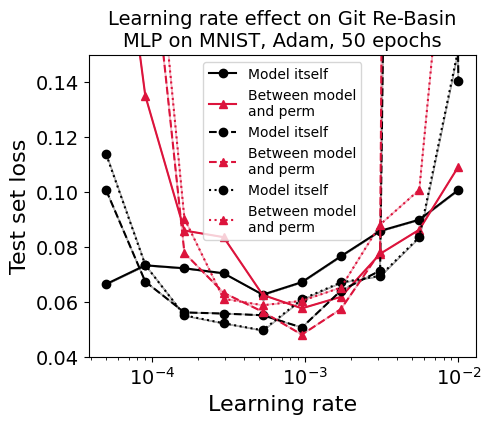

In [35]:
fig = plt.figure(figsize = (5,4),dpi=100)
fig.patch.set_facecolor('white')

plt.title(f"Learning rate effect on Git Re-Basin\nMLP on MNIST, Adam, {epochs} epochs",fontsize=14)
line_styles = ["solid", "dashed", "dotted"]
for i, stored_results_dict in enumerate(all_results):
  standard_bumps = np.array([d["bump_1_to_2"] for d in stored_results_dict])
  permuted_bumps = np.array([d["bump_1_to_2perm"] for d in stored_results_dict])
  model1_loss = np.array([d["model1_test_loss"] for d in stored_results_dict])
  model2_loss = np.array([d["model2_test_loss"] for d in stored_results_dict])
  
  standard_bumps = np.reshape(standard_bumps,[reps,-1])
  permuted_bumps = np.reshape(permuted_bumps,[reps,-1])
  model1_loss = np.reshape(model1_loss,[reps,-1])
  model2_loss = np.reshape(model2_loss,[reps,-1])
  
  def get_mean_and_error(vals):
    return np.mean(vals,axis=0), np.std(vals,axis=0)
  
  mean_standard_bumps, error_standard_bumps = get_mean_and_error(standard_bumps)
  mean_permuted_bumps, error_permuted_bumps = get_mean_and_error(permuted_bumps)    
  mean_model1_loss, error_model1_loss = get_mean_and_error(model1_loss)
  mean_model2_loss, error_model2_loss = get_mean_and_error(model2_loss)
  
  
  line, = plt.semilogx(LRs[:len(mean_standard_bumps)],(mean_model1_loss+mean_model2_loss)/2.0,marker="o",color="black",linestyle=line_styles[i],label="Model itself")
  plt.fill_between(LRs[:len(mean_standard_bumps)],
                   (mean_model1_loss+mean_model2_loss)/2.0-(error_model1_loss+error_model2_loss)/2.0,
                   (mean_model1_loss+mean_model2_loss)/2.0+(error_model1_loss+error_model2_loss)/2.0,
                   color=line.get_color(),
                   alpha=0.3
                   )
  
  #line, = plt.semilogx(LRs[:len(mean_standard_bumps)],mean_standard_bumps,marker="s",color="navy",label="Between models",linestyle=line_styles[i])
  #plt.fill_between(LRs[:len(mean_standard_bumps)],mean_standard_bumps-error_standard_bumps,mean_standard_bumps+error_standard_bumps,alpha=0.3,color=line.get_color())
  
  line, = plt.semilogx(LRs[:len(mean_standard_bumps)],mean_permuted_bumps,marker="^",color="crimson",label="Between model\nand perm",linestyle=line_styles[i])
  plt.fill_between(LRs[:len(mean_standard_bumps)],mean_permuted_bumps-error_permuted_bumps,mean_permuted_bumps+error_permuted_bumps,alpha=0.3,color=line.get_color())
  
from matplotlib.patches import Rectangle
currentAxis = plt.gca()
#currentAxis.add_patch(Rectangle((LRs[0], 0.0),LRs[3]-LRs[0],3.0, fill=True, color="green", alpha=0.3))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Learning rate",fontsize=16)
plt.ylabel("Test set loss",fontsize=16)
plt.ylim([0.04,0.15])

plt.legend(fontsize=10)
plt.show()
  